In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import linear_model as lm
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score
import seaborn as sns
from stop_words import get_stop_words
import Stemmer
import pymorphy2
from segtok import segmenter
import re
from functools import partial
import pickle
import xgboost as xgb 
%matplotlib inline

/home/digitman/miniconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Loading data

In [2]:
data = pd.read_csv('data/comments_vrn.csv.gz')

In [3]:
data.shape

(193539, 6)

In [4]:
data.is_gum.value_counts()

0.0    111199
1.0     82340
Name: is_gum, dtype: int64

In [5]:
data.head(3)

,from_id,text,is_gum,hour,likes,sex
0,170328895,А еще сегодня у нас в Советском районе нашлы м...,1.0,13,9,1
1,170328895,"[id231306085|Алиса], не слышала такой информац...",1.0,13,0,1
2,170328895,"Алиса, хорошо бы ,у нас ни от кого такой инфор...",1.0,13,0,1


## Examples of two classes

In [6]:
data[data.is_gum == False].text.sample(10).values

array(['Как можно быть с полторахи пиваса готовым ...!?😑', '89038575968',
       '[id41103994|Сергей], ребята на скорой шлют нахуй! и приезжают когда хотят с аргументами у нас людей не хватает надо не жалобы писать а иски и как минздрав пару раз иск проиграет тогда они у нас и штат наберут)))',
       'у нас в городе тоже такая фигня была. Обещали на две недели, а не было почти два месяца',
       'И через месяц водохранка зацветет и в ней замурлыкают крокодилы 😉',
       '[id244198838|Андрей], по крайней мере я такого чтоб годами зарплату не платили не встречал.',
       'Почему нет дневного чата , мне скучно на физике',
       '[id286100158|Аленка], можно, но смотри аккуратнее с носком, а то запах носка придётся запивать боярышником. носок дело тонкое )))',
       '[id145992746|Максим], Давно - не значит, что их нету. А вот за 7-8 я вам за полчаса найду приемлемый вариант.\nЭто к тому, что я ессно искать не буду, а к тому, что это МОЖНО найти, причём без проблем. Тем более, что сейча

In [7]:
data[data.is_gum == True].text.sample(10).values

array(['[id142920305|Вадим], переезжай в Врн!!! 😃', '21',
       'Блин, я вчера и такую пищу пропустил...Сколько бы я дерьма на вентилятор вбросил((((((',
       'Тетки, пиздите своих детей! Только так можно воспитать',
       '[id146490182|Алёна], че то слишком старый)', '54',
       '[id354748612|Рита], я тебе могу сказать если это делается по обоюдному желанию! то наказания нет , так кая девочка сама согласилась на это!',
       '[id168926563|Мистер], как остроумно 😑',
       'видимо все малярийные комары по знаку зодака львы',
       '8⃣9⃣5⃣0⃣7⃣6⃣9⃣3⃣3⃣1⃣7⃣'], dtype=object)

# Preprocessing

## Words count

In [8]:
lenghts_word = np.array([len(m.split()) for m in data.text.values])

In [9]:
lenghts_word.mean(), np.median(lenghts_word)

(11.219397640785578, 6.0)

In [10]:
comments = data[(lenghts_word < 60) & (lenghts_word > 3)]
comments.shape

(134898, 6)

## Links

In [11]:
links = [m for m in data.text.values if 'http' in m or 'www' in m or '.ru' in m or '.com' in m] 
print('{:.2f}% of comments contain links'.format(len(links) / len(data) * 100))

0.46% of comments contain links


In [12]:
without_link = [False if 'http' in c or 'www' in c or '.ru' in c or '.com' in c else True
                for c in comments.text.values] 

In [13]:
comments = comments[without_link]

In [14]:
comments.shape

(134325, 6)

# Droping outliers

In [15]:
from sklearn.ensemble import IsolationForest

In [16]:
vectorizer = CountVectorizer(max_features=1000, ngram_range=(3, 3), analyzer='char')
X = vectorizer.fit_transform([' '.join(t.split()[:4]) for t in comments.text.values])
y = comments.is_gum.values
# y = comments.sex.values

In [17]:
forest = IsolationForest(200, contamination=0.01, n_jobs=-1)
forest.fit(X)
X_pred = forest.predict(X)
comments['len'] = [len(t) for t in comments.text.values]
comments['outlier'] = X_pred

In [18]:
comments[comments.outlier == -1].head(10).text.values

array([ '[id157428002|Анна], не расстраивайтесь....будете в Подгорном - посмотрите какие там дома эти этногруппы себе отстроили за наш с вами счет',
       '[id259154163|Максим], всякое бывало....просто лейтенант....я был молодой',
       '[id84212618|Виктор], кто репостит-тем более😖',
       '[id91889000|Александр], ничего страшного. Всё что мы пьём, уже когда-то пили😏',
       '[id11420305|Василий], наверное потому что до лета еще рановато😏',
       '[id216426111|Марфа-Васильевна], парковка слава богу нет, а вот поставить машину можно было нигде',
       '[id7446980|Алёна], хоть какая-то стабильность😉',
       '[id68148212|Сергей], мобильное приложение если только)',
       '[id16867860|Дмитрий], тогда вся Москва Ваша. 👍',
       '[id16867860|Дмитрий], все куда-то спешат, верно?)))\nВозвращайтесь, Воронежские девушки тут долго не ждут.'], dtype=object)

In [19]:
comments.groupby('outlier').mean()

,from_id,is_gum,hour,likes,sex,len
outlier,,,,,,
-1,1.085356e+08,0.499256,10.562500,0.473958,1.531994,99.658482
1,9.069213e+07,0.427347,12.658026,1.242501,1.678947,83.985306


## Emoji

In [20]:
comments_list = comments.text.values

In [21]:
with open('meta_data/emoji.txt', 'r') as f:
    lines = f.readlines()
emojis = [line[0] for line in lines]

In [22]:
def is_with_emoji(comment):
    for em in emojis:
        if em in comment:
            return 1
    return 0

In [23]:
def with_emoji(comments):
    return [is_with_emoji(c) for c in comments]

In [24]:
def get_emoji(comment, repetition=True):
    ems = []
    for em in emojis:
        if not repetition:
            if em in comment:
                ems.append(em)
        else:
            founded = re.findall(em, comment)
            if len(founded) > 0:
                ems.extend(founded)
    return ems

#### If not done before

In [25]:
len(comments_list)

134325

In [38]:
# %time emoji_from_comments_rep = list(map(get_emoji, comments_list))

CPU times: user 1h 35min 58s, sys: 804 ms, total: 1h 35min 59s
Wall time: 1h 37min 14s


In [39]:
# with open('meta_data/emoji_from_comments_vrn_final.pkl', 'wb') as f:
#     pickle.dump(emoji_from_comments_rep, f)

#### Else load

In [26]:
with open('meta_data/emoji_from_comments_vrn_final.pkl', 'rb') as f:
    emoji_from_comments_rep = pickle.load(f)
emoji_from_comments_no_rep = list(map(lambda com: get_emoji(com, False), comments_list))
len(comments_list), len(emoji_from_comments_rep)

(134325, 134325)

In [27]:
def get_emoji_proportion(comments, emoji_from_coms=None, repetition=True):
    emoji_proportion = [] 
    func = lambda com: get_emoji(com, repetition)
    if not emoji_from_coms:
        emoji_from_coms = list(map(func, comments))
    
    for i in range(len(comments)):
        com = re.sub(' *', '', comments[i])
        emoji_proportion.append(len(emoji_from_coms[i]) / len(com))
    return np.array(emoji_proportion)

In [28]:
em_proportion_rep = get_emoji_proportion(comments_list, emoji_from_comments_rep)
em_proportion_no_rep = get_emoji_proportion(comments_list, emoji_from_comments_no_rep)

### With repetition

In [29]:
print((em_proportion_rep > 0.12).sum())
comments_list[em_proportion_rep > 0.12][:10]

528


array(['С днем рождения, Легенда❤❤❤', 'больно Вы мне нужны😂😂😂',
       'кто это слушает? 😀😀', 'Это разве так важно?😀😀😀',
       'на логотип Pepsi похоже😋😋😋', 'Так это же провод 😀😀',
       'Да не за что😄😄', 'А "неправильно" - слитно 😄😄😄',
       'Есть✋🏻Зожники не бухают 😄', 'Я бы собачек накормила 🤗🤗🤗'], dtype=object)

### Without repetition

In [30]:
print((em_proportion_no_rep > 0.08).sum())
comments_list[em_proportion_no_rep > 0.08][:10]

463


array(['Цой жив💋\nС днем рождения 😔', 'не люблю море 😄', 'Да не за что😄😄',
       'Есть✋🏻Зожники не бухают 😄',
       'Зачеет😂👍🏻 А как он туда забрался? Я тоже хочу',
       'Классный мужик, классный Ленинград 😍👍🏻',
       'Все деньги на качалку ушли 😀😆', 'Так оно и есть 😄',
       'Спасибо за информацию 😇👍🏻', 'Пойду кота поцелую 😄❤'], dtype=object)

### Proportion of alphabetical symbols

In [31]:
def get_abc_proportion(comments):
    abc_proportion = []     
    for i in range(len(comments)):
        com = re.sub(' *', '', comments[i])
        abc = re.findall('[а-яёa-z]', com, flags=re.IGNORECASE)
        abc_proportion.append(len(abc) / len(com))
    return np.array(abc_proportion)

In [32]:
abc_proportion = get_abc_proportion(comments_list)

In [33]:
sum(abc_proportion < 0.5)

1018

In [34]:
comments_list[abc_proportion < 0.5][:10]

array(['Это как такъ ???????????',
       '[id191122455|Катерина], что я...да так)))☺☺☺☺',
       ".∧＿∧ \n( ･ω･｡)つ━☆・*。 \n⊂\u3000 ノ \u3000\u3000\u3000・゜+. \nしーＪ\u3000\u3000\u3000°。+ *´¨) \n\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000.· ´¸.·*´¨) ¸.·*¨) \n\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000(¸.·´ (¸.·'* вжух,магия баяна",
       '[id195857273|Alexis], году в 2003',
       '[id137387704|Юля], а чего так хмуро?))))💐',
       '[id302984120|永恒的], а, вот ты где.',
       '[id140593667|Юля], о том, что уже 0:22',
       '[id20683885|Ольга], я в шоке😱😱😱😱',
       '[id166215931|Милена], около 1,2 млн.',
       '[id215978004|Mac], по Воронежу 12-25 т. р. зп😌'], dtype=object)

### Filling DataFrame

In [35]:
comments['emojis'] = [' '.join(e) for e in emoji_from_comments_rep]
comments['em_proportion_rep'] = em_proportion_rep
comments['em_proportion_no_rep'] = em_proportion_no_rep
comments['abc_proportion'] = abc_proportion

In [36]:
comments.head(3)

,from_id,text,is_gum,hour,likes,sex,len,outlier,emojis,em_proportion_rep,em_proportion_no_rep,abc_proportion
0,170328895,А еще сегодня у нас в Советском районе нашлы м...,1.0,13,9,1,133,1,,0.0,0.0,0.955752
1,170328895,"[id231306085|Алиса], не слышала такой информац...",1.0,13,0,1,62,1,,0.0,0.0,0.727273
2,170328895,"Алиса, хорошо бы ,у нас ни от кого такой инфор...",1.0,13,0,1,123,1,,0.0,0.0,0.920792


#### If message repeats more than one time - drop (spam)

In [37]:
print('{} different spam comments'.format((comments.text.value_counts() > 1).sum()))

318 different spam comments


In [38]:
print('{} total count of spam comments'
      .format(comments.text.value_counts()[comments.text.value_counts() > 1].values.sum()))

989 total count of spam comments


### Dropping outlier

In [39]:
spam_comments = comments.text.value_counts()[comments.text.value_counts() > 1].keys()
comments = comments[comments.text.apply(lambda t: t not in spam_comments)]

In [40]:
index_to_del = comments[(comments.em_proportion_rep > 0.12).values | (comments.abc_proportion < 0.5).values | 
                        (comments.text.value_counts() != 1).values |
                        (comments.em_proportion_no_rep > 0.08).values].index

In [41]:
index_to_del.shape

(1578,)

In [42]:
comments.drop(index_to_del, inplace=True)

In [43]:
comments.shape

(131758, 12)

In [44]:
comments_list = comments.text.values

### Replacing id

In [45]:
comments_list = []
for comment in comments.text.values:
    c = comment.split()
    if c[0].startswith('[id'):
        c[0] = 'имя'
    c_ = []
    for w in c:
        if w.startswith('id'):
            c_.append('имя')
        else:
            c_.append(w)
    comments_list.append(' '.join(c))
comments_list = np.array(comments_list)

In [46]:
comments_list[:3]

array([ 'А еще сегодня у нас в Советском районе нашлы мужчину расчлененого ,так что не факт что только на женщин нападает)Придонской гремит)))',
       'имя не слышала такой информации ,все боятся )',
       'Алиса, хорошо бы ,у нас ни от кого такой информации нет .Но Придонской это Советский район ,у нас не один маньяк что ли?)))'], 
      dtype='<U515')

In [47]:
comments.text = comments_list

# Balancing by sex

### Not sure

In [49]:
# comments.reset_index(drop=True, inplace=True)

In [50]:
# comments.sex.value_counts()

2    89296
1    42462
Name: sex, dtype: int64

In [52]:
# delta = comments.sex.value_counts()[2] - comments.sex.value_counts()[1]

In [56]:
# temp = comments[comments['sex'] == 2]

In [54]:
# delta

46834

In [57]:
# to_del_indexes = temp.index.values
# np.random.shuffle(to_del_indexes)
# to_del_indexes = to_del_indexes[:delta]

In [59]:
# comments_ = comments.copy()

In [60]:
# comments.drop(to_del_indexes, inplace=True)

In [61]:
# comments = pd.concat((comments, temp))

In [76]:
# comments.shape

In [62]:
# comments_list = comments.text.values

In [63]:
# comments.sex.value_counts()

2    42462
1    42462
Name: sex, dtype: int64

In [107]:
# comments.is_gum.value_counts()

0.0    42719
1.0    42205
Name: is_gum, dtype: int64

# Clearing comments

In [48]:
y = comments.is_gum.values
adj_proportion = []
errors = []

In [49]:
def clear_comments(comments, with_stemmer=False, with_lemmer=True, to_lower=True, without_names=False,
                without_stop_words=False, min_word_len=None, with_emoji=False):
    global adj_proportion
    global errors 
    adj_proportion = []
    errors = []
    clear_comments = []
    stop_words = set(get_stop_words('ru'))
    stemmer = Stemmer.Stemmer('russian')
    lemmer = pymorphy2.MorphAnalyzer()
    
    names_del = 0
    i = -1
    for comment in comments:
        comment_ = comment
        i += 1
        if to_lower:
            comment = comment.lower()
        comment = re.sub('[^а-яА-ЯёЁa-zA-Z\-]', ' ', comment)
        comment = comment.split()
        if without_stop_words:
            comment = [c for c in comment if c not in stop_words]
        if with_stemmer:
            comment = stemmer.stemWords(comment)
            if without_names:
                with open('meta_data/names_from_sent.txt', 'r') as f:
                    names = f.readlines()
                    names = set([name.strip() for name in names])
                before = len(comment)
                comment = [c for c in comment if c not in names]
                aft = len(comment)
                names_del += before - aft
        elif with_lemmer:
            parsed = [lemmer.parse(c)[0] for c in comment]
            comment = [p.normal_form for p in parsed]
            adj = sum([1 for p in parsed if 'ADJ' in str(p.tag)])
            if len(comment) == 0:
                errors.append(comment_)
                adj_proportion.append(0)
            else:
                adj_proportion.append(adj / len(comment))
            if without_names:
                with open('meta_data/names.txt', 'r') as f:
                    names = f.readlines()
                    names = set([name.strip() for name in names])
                    before = len(comment)
                    comment = [c for c in comment if c not in names]
                    aft = len(comment)
                    names_del += before - aft
        if min_word_len is not None:
            comment = [c for c in comment if len(c) >= min_word_len]
        if with_emoji:
            comment.extend(emoji_from_comments_rep[i])
        clear_comments.append(' '.join(comment))
    print('names del: {}'.format(names_del))
    return clear_comments

### Word

In [50]:
%%time
clear_coms = clear_comments(comments_list, min_word_len=3, with_emoji=True, with_stemmer=False,
                            with_lemmer=True, without_names=True, without_stop_words=False)

names del: 8877
CPU times: user 11min 43s, sys: 8.25 s, total: 11min 52s
Wall time: 12min 9s


In [51]:
comments['clear_text'] = clear_coms

In [52]:
comments.head(2)

,from_id,text,is_gum,hour,likes,sex,len,outlier,emojis,em_proportion_rep,em_proportion_no_rep,abc_proportion,clear_text
0,170328895,А еще сегодня у нас в Советском районе нашлы м...,1.0,13,9,1,133,1,,0.0,0.0,0.955752,ещё сегодня советский район нашлый мужчина рас...
1,170328895,"имя не слышала такой информации ,все боятся )",1.0,13,0,1,62,1,,0.0,0.0,0.727273,имя слышать такой информация весь бояться


In [53]:
errors[:10]

[]

In [54]:
clear_coms[10:15]

['имя написать',
 'имя там тоже открытый личка',
 'имя так реально что большой 😂',
 'имя даже если человек выпивать весь ровно они человек они жалко',
 'смешной конечно женщина']

In [55]:
adj_proportion[10:15]

[0.0, 0.2, 0.0, 0.08333333333333333, 0.25]

In [56]:
%%time
vectorizer = CountVectorizer(max_features=10000, min_df=100, ngram_range=(1, 2), analyzer='word')
word_features = vectorizer.fit_transform(clear_coms)

CPU times: user 8.57 s, sys: 84 ms, total: 8.66 s
Wall time: 8.66 s


In [57]:
np.array(vectorizer.get_feature_names())[np.random.randint(0, 1000, 20)]

array(['находиться', 'обращаться', 'задолбать', 'беда', 'видео', 'бензин',
       'видимо', 'близкие', 'зато', 'главный что', 'обратиться', 'крупный',
       'ибо', 'невозможно', 'много', 'если быть', 'видно что', 'вокруг',
       'жить', 'быть'], 
      dtype='<U18')

In [58]:
lr = lm.LogisticRegression()

In [59]:
np.mean(cross_val_score(lr, word_features, comments.is_gum, cv=5))

0.55359819702707114

# Features

### Is the first letter of sentence upper

In [60]:
def sentence_stat(comments):
    big_letter = []
    sents_count = []
    for comment in comments:
        sents = list(segmenter.split_single(re.sub('(\)+|\.+)', '\n', comment)))
        count = sum([1 for sent in sents if sent and (sent[0].isupper() or 'имя' in sent
                                                      or (len(sent) > 1 and sent[0] == '"' and sent[1].isupper()))])
        total = sum([1 for sent in sents if sent.strip() != ''
                     and re.match('.*[a-zа-яё].*', sent.strip(), flags=re.IGNORECASE)])
        # print(count, total)
        if total:
            big_letter.append(count // total)
        else:
            big_letter.append(1)
        if total > 3:
            total = 4
        if total < 1:
            total = 1
        sents_count.append(total)
    return np.array(big_letter), np.array(sents_count)

In [61]:
%%time
big_letter, sents_count = sentence_stat(comments_list)

CPU times: user 5.56 s, sys: 0 ns, total: 5.56 s
Wall time: 5.56 s


In [62]:
pd.Series(sents_count).value_counts()

1    75753
2    33895
3    12450
4     9660
dtype: int64

In [63]:
pd.Series(sents_count[y.astype(bool)]).value_counts(True)

1    0.559730
2    0.264190
3    0.100222
4    0.075858
dtype: float64

In [64]:
pd.Series(sents_count[~y.astype(bool)]).value_counts(True)

1    0.586322
2    0.252060
3    0.090203
4    0.071414
dtype: float64

In [65]:
pd.Series(big_letter).value_counts()

1    93185
0    38573
dtype: int64

### Punctuation count in comment

In [66]:
def punctuation_counts(comments, pattern='\(+', partion=False):
    if partion:
        return [sum(len(p) for p in re.findall(pattern, c)) / len(c) for c in comments]
    else:
        return [1 if len(re.findall(pattern, c)) > 0 else 0 for c in comments]

In [67]:
commas = punctuation_counts(comments_list, pattern='[\.]{2,}', partion=False)

In [68]:
pd.Series(commas).value_counts()

0    113044
1     18714
dtype: int64

### Mean word length

In [69]:
def mean_word_length(comments):
    lengths = []
    for comment in comments:
        comment = comment.lower()
        comment = re.sub('[^а-яё\-]', ' ', comment).split()
        ls = [len(w) for w in comment]
        if len(ls):
            lengths.append(sum(ls) / len(ls))
        else:
            lengths.append(1)
    return lengths

In [70]:
mean_length = mean_word_length(comments_list)

### Caps WORD

In [71]:
def caps_words(comments, partion=False):
    caps = []
    for comment in comments:
        count = len(re.findall('[А-ЯЁA-Z\-]{4,}', comment))
        total = len(comment.split())
        if partion and total != 0:
            caps.append(count / total * 100)
        else:
            caps.append(1 if count > 0 else 0)
    return caps

In [72]:
caps = caps_words(comments_list, False)

In [73]:
pd.Series(caps).value_counts()

0    128178
1      3580
dtype: int64

### English words

In [74]:
def eng_words(comments, partion=False):
    engs = []
    for comment in comments:
        count = len([w for w in re.findall('[a-z\-]{3,}', comment, flags=re.IGNORECASE) if w != 'имя'])
        total = len(comment.split())
        if partion and total != 0:
            engs.append(count / total * 100)
        else:
            engs.append(1 if count > 0 else 0)
    return engs

In [75]:
engs = eng_words(comments_list, False)

In [76]:
pd.Series(engs).value_counts()

0    129737
1      2021
dtype: int64

### Total words

In [77]:
def total_words(comments):
    return [len(com.split()) if len(com.split()) < 25 else 25 for com in comments]

In [78]:
words_count = total_words(comments_list)

In [79]:
pd.Series(words_count).value_counts()[:10]

25    15464
4     14525
5     13609
6     12380
7     10582
8      9198
9      7848
10     6821
11     5759
12     5133
dtype: int64

### Total chars

In [80]:
def total_chars(comments):
    return [len(com) if len(com) < 100 else 100 for com in comments]

In [81]:
chars_count = total_chars(comments_list)

In [82]:
pd.Series(chars_count).value_counts()[:10]

100    30216
28      2174
30      2155
26      2138
27      2127
31      2121
29      2091
33      2074
25      2070
32      2064
dtype: int64

### All comments features together

In [83]:
from sklearn.feature_selection import VarianceThreshold

In [84]:
def get_comments_features(coms):
    features = pd.DataFrame()
    features['with_emoji'] = with_emoji(coms)
    big_letter, sents_count = sentence_stat(coms)
    features['big_letter'] = big_letter
    features['sents_count'] = sents_count
    features['punct_)'] = punctuation_counts(coms, pattern='\)+')
    features['punct_('] = punctuation_counts(coms, pattern='\(+')
    features['punct_?'] = punctuation_counts(coms, pattern='\?+')
    features['punct_!'] = punctuation_counts(coms, pattern='\!+')
    features['punct_..'] = punctuation_counts(coms, pattern='[\.]{2,}')
    features['punct_1-9'] = punctuation_counts(coms, pattern='[0-9]{1,}')
    features['punct_"'] = punctuation_counts(coms, pattern='".+"')
    features['eng_words'] = eng_words(coms, True)
    features['mean_word_len'] = mean_word_length(coms)
    features['caps'] = caps_words(coms)
    features['em_proportion_rep'] = comments['em_proportion_rep'].values
    features['em_proportion_no_rep'] = comments['em_proportion_no_rep'].values
    # features['adj_proportion'] = adj_proportion
    features['abc_proportion'] = comments['abc_proportion'].values
    features['words_count'] = total_words(coms)
    features['chars_count'] = total_chars(coms)
    return features

In [85]:
comment_features = get_comments_features(comments_list)

In [86]:
comment_features_list = comment_features.columns.tolist()

In [87]:
comment_features.describe()

,with_emoji,big_letter,sents_count,punct_),punct_(,punct_?,punct_!,punct_..,punct_1-9,"punct_""",eng_words,mean_word_len,caps,em_proportion_rep,em_proportion_no_rep,abc_proportion,words_count,chars_count
count,131758.000000,131758.000000,131758.000000,131758.000000,131758.000000,131758.000000,131758.000000,131758.000000,131758.000000,131758.000000,131758.000000,131758.000000,131758.000000,131758.000000,131758.000000,131758.000000,131758.000000,131758.000000
mean,0.107348,0.707244,1.666183,0.230627,0.042396,0.202652,0.125776,0.142033,0.119439,0.053113,0.297779,4.662089,0.027171,0.003154,0.002672,0.834683,11.547155,59.567396
std,0.309557,0.455029,0.922643,0.421236,0.201491,0.401977,0.331598,0.349085,0.324305,0.224259,3.316524,0.970924,0.162582,0.011219,0.009081,0.120017,6.913353,29.130016
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.500000,4.000000,7.000000
25%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.746667,6.000000,33.000000
50%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.600000,0.000000,0.000000,0.000000,0.861702,9.000000,54.000000
75%,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.200000,0.000000,0.000000,0.000000,0.937500,16.000000,94.000000
max,1.000000,1.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,110.000000,37.000000,1.000000,0.120000,0.080000,1.000000,25.000000,100.000000


In [88]:
from sklearn import ensemble
from xgboost import XGBClassifier

In [89]:
X = comment_features.values

In [90]:
X.shape

(131758, 18)

In [91]:
rf = ensemble.RandomForestClassifier(100, n_jobs=-1)

In [92]:
baseline_scores = cross_val_score(rf, X, y, cv=5)
print(baseline_scores.mean(), baseline_scores.std())

0.524119976045 0.00647896243553


---

In [93]:
gb = XGBClassifier()

In [94]:
baseline_scores = cross_val_score(gb, X, y, cv=5)
print(baseline_scores.mean(), baseline_scores.std())

0.549560696258 0.0187862997332


---

In [95]:
lr = lm.LogisticRegression()

In [96]:
baseline_scores = cross_val_score(lr, X, y, cv=5)
print(baseline_scores.mean(), baseline_scores.std())

0.551291135363 0.0146654394571


### Feature selection

In [97]:
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression, RFE, SelectFromModel

In [98]:
sel = VarianceThreshold(0.5)
sel.fit(X, y)
X_ = sel.transform(X)

In [99]:
X_.shape

(131758, 5)

In [100]:
baseline_scores = cross_val_score(lr, X_, y, cv=5)
print(baseline_scores.mean(), baseline_scores.std())

0.568997751894 0.00634862669786


---

In [101]:
sel = SelectKBest(f_regression, 3)
sel.fit(X, y)
X_ = sel.transform(X)

In [102]:
X_.shape

(131758, 3)

In [103]:
baseline_scores = cross_val_score(lr, X_, y, cv=5)
print(baseline_scores.mean(), baseline_scores.std())

0.571980448857 7.9572963883e-06


In [104]:
lr.fit(X_, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [105]:
list(zip(comment_features.columns.values[sel.get_support()], lr.coef_.ravel()))

[('punct_)', 0.1793406878278998),
 ('punct_1-9', -0.23030668960813599),
 ('caps', -0.47574972715584235)]

Then coef higher, probability of gum class higher

---

In [106]:
sel = RFE(lr, 3)
sel.fit(X, y)
X_ = sel.transform(X)

In [107]:
X_.shape

(131758, 3)

In [108]:
comments.is_gum.value_counts()

0.0    75363
1.0    56395
Name: is_gum, dtype: int64

In [109]:
baseline_scores = cross_val_score(lr, X_, y, cv=5)
print(baseline_scores.mean(), baseline_scores.std())

0.571722403927 0.000512892749374


---

In [110]:
sel = lm.RandomizedLasso(sample_fraction=0.5, scaling=0.02, n_resampling=500, selection_threshold=0.99)
sel.fit(X, y)
X_ = sel.transform(X)

In [111]:
X_.shape

(131758, 12)

In [112]:
rf.fit(X_, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [113]:
sorted(list(zip(rf.feature_importances_, comment_features.columns.values[sel.get_support()])), key=lambda x: -x[0])

[(0.43514261855315445, 'abc_proportion'),
 (0.32627241282819575, 'mean_word_len'),
 (0.12378738253736431, 'words_count'),
 (0.041588554345124769, 'em_proportion_no_rep'),
 (0.024123597997092329, 'sents_count'),
 (0.009978840619813743, 'punct_!'),
 (0.0096670931996321284, 'punct_?'),
 (0.0077924149249659624, 'eng_words'),
 (0.006809006148788729, 'punct_)'),
 (0.005760069904246528, 'punct_1-9'),
 (0.0051693791687800776, 'punct_"'),
 (0.0039086297728411499, 'caps')]

In [114]:
comments = pd.concat((comments.reset_index(drop=True), comment_features.reset_index(drop=True)),
                     axis=1, ignore_index=False)

# Cross validation method

## Grouping by user

In [115]:
def make_df_balanced(df, by_col):
    """Make df balanced by binary columns named - by_col. Using oversampling"""
    big_class = 0
    small_class = 1
    if df[by_col].value_counts()[0] < df[by_col].value_counts()[1]:
        big_class = 1
        small_class = 0
    
    delta = df[by_col].value_counts()[big_class] - df[by_col].value_counts()[small_class]
    only_ing = df[df[by_col] == small_class]
    to_add_indexes = np.random.randint(0, len(only_ing) - 1, delta)
    df = pd.concat((df, only_ing.iloc[to_add_indexes]))

    # shuffle after adding
    df = df.iloc[np.random.permutation(df.shape[0])]
    return df

In [152]:
def fit_predict_to_n_user(comments, models, n=10, use_cache=True, debug=True, debug_score=True,
                          with_additional=True, predict_proba=False, return_prediction=False):
    unique_ids = None
    if use_cache:
        with open('unique_ids_{}.pkl'.format(n), 'rb') as f:
            unique_ids = pickle.load(f)
    else:
        unique_ids = comments.from_id.value_counts()[comments.from_id.value_counts() >= n].index.values
        additional_ids = comments.from_id.value_counts()[comments.from_id.value_counts() < n].index.values
#         with open('unique_ids_{}.pkl'.format(n), 'wb') as f:
#             pickle.dump(unique_ids, f)
    
    if debug:
        print('{} - uniq peoples'.format(len(unique_ids)))
        print('{} - additional peoples'.format(len(additional_ids)))
    
    train_idxs = unique_ids[:int(len(unique_ids) * 0.8)]
    test_idxs = unique_ids[int(len(unique_ids) * 0.8):]

    train_comments = comments[[i in train_idxs for i in comments.from_id]]
    additional_comments = comments[[i in additional_ids for i in comments.from_id]]
    train_comments = pd.concat((train_comments.reset_index(drop=True), additional_comments.reset_index(drop=True)))

    test_comments = comments[[i in test_idxs for i in comments.from_id]]

    if debug:
        print('Before sampling:')
        print(train_comments.is_gum.value_counts())
        print('Additional comments:')
        print(additional_comments.shape[0])
    
    train_comments = make_df_balanced(train_comments, 'is_gum')
    
    X_train, X_test = train_comments, test_comments
    y_train, y_test = train_comments.is_gum.values, test_comments.is_gum.values
    
    # models
    prediction_df = pd.DataFrame()
    if debug_score:
        print('Accuracy for comment:')
    
    cols = []
    for model in models:
        cols.append(model.name)
        model.fit(X_train, y_train)
        
        if predict_proba:
            prediction = model.predict_proba(X_test)
            if prediction.shape[1] > 1:
                prediction = prediction[:, 1]
            else:
                prediction = prediction.ravel()
        else:
            prediction = model.predict(X_test)
        prediction_df[model.name] = prediction
        
        if debug_score:
            print('Model: ', model.name)
            if predict_proba:
                print(accuracy_score(y_test, prediction > 0.5))
            else:
                print(accuracy_score(y_test, prediction))
                
    if predict_proba:
        prediction_df['prediction'] = prediction_df.mean(axis=1)
    else:
        prediction_df['prediction'] = prediction_df.median(axis=1)
        
    if debug_score:
        if predict_proba:
            print('Mean of models:', accuracy_score(y_test, (prediction_df['prediction'].values > 0.5).astype(int)))
        else:
            print('Median of models:', accuracy_score(y_test, prediction_df['prediction'].values.astype(int)))
    # print(test_comments.shape, prediction_df.shape)
    test_comments = pd.concat((test_comments.reset_index(drop=True), prediction_df.reset_index(drop=True)), axis=1)
    # print(test_comments.shape)
    # test_comments['prediction'] = prediction
    # y_true = test_comments.groupby('from_id').agg(np.median)['is_gum'].values
    # return test_comments
    if predict_proba:
        grouped_median_test = test_comments.groupby('from_id').agg(np.mean)
    else:
        grouped_median_test = test_comments.groupby('from_id').agg(np.median)
    # return test_comments.groupby('from_id')[cols].agg(np.median)
    y_true = grouped_median_test['is_gum'].values
    # print(y_true[:3])
    if debug_score:
        print('Accuracy for user:')

    for model in models:
        y_pred = grouped_median_test[model.name].values
        # print(y_pred[:3])
        # y_pred = np.floor(test_comments.groupby('from_id').agg(np.median)['prediction'].values)
        if debug_score:
            print('Model: ', model.name)
            if predict_proba:
                print(accuracy_score(y_true, (y_pred > 0.5).astype(int)))
            else:
                print(accuracy_score(y_true, y_pred.astype(int)))

    if predict_proba:
        y_pred_proba = grouped_median_test[cols].mean(axis=1).values
        y_pred = (y_pred_proba > 0.5).astype(int)
    else:
        y_pred = np.floor(grouped_median_test[cols].median(axis=1).values).astype(int)
    med_of_models_score = accuracy_score(y_true, y_pred)
    
    if predict_proba:
        y_pred = (grouped_median_test['prediction'].values > 0.5).astype(int)
    else:
        y_pred = np.floor(grouped_median_test['prediction'].values).astype(int)
    med_of_av_models_score = accuracy_score(y_true, y_pred)
    
    if debug_score:
        print('Median of models averaged per user:')
        print(med_of_models_score)
    
    if debug_score:
        print('Median of averaged model per user:')
        print(med_of_av_models_score)
    
    if return_prediction: # for debug
        return med_of_models_score, med_of_av_models_score, prediction_df, y_test
    else:
        return med_of_models_score, med_of_av_models_score

In [127]:
class Model:
    def __init__(self, name='-'):
        self.name = name
        
    def fit(self, X, y):
        raise NotImplemented()
    
    def predict(self, X):
        raise NotImplemented()
    
    def predict_proba(self, X):
        raise NotImplemented()

In [128]:
class LrModelCount(Model):
    def __init__(self, name='-', max_features=1000, analyzer='word', ngram_range=(1, 1)):
        super().__init__(name)
        self.vectorizer = CountVectorizer(max_features=max_features, analyzer=analyzer, ngram_range=ngram_range)
        self.model = lm.LogisticRegression()
        self._fitted = False
        
    def fit(self, X, y):
        X = self.vectorizer.fit_transform(X.text.values)
        self.model.fit(X, y)
        self._fitted = True
    
    def predict(self, X):
        if not self._fitted:
            raise Exception('Not fitted yet')
        X = self.vectorizer.transform(X.text.values)
        return self.model.predict(X)
    
    def predict_proba(self, X):
        if not self._fitted:
            raise Exception('Not fitted yet')
        X = self.vectorizer.transform(X.text.values)
        return self.model.predict_proba(X)

In [129]:
class LrModelCountClear(Model):
    def __init__(self, name='-', max_features=1000):
        super().__init__(name)
        self.vectorizer = CountVectorizer(max_features=max_features)
        self.model = lm.LogisticRegression()
        self._fitted = False
        
    def fit(self, X, y):
        X = self.vectorizer.fit_transform(X.clear_text.values)
        self.model.fit(X, y)
        self._fitted = True
    
    def predict(self, X):
        if not self._fitted:
            raise Exception('Not fitted yet')
        X = self.vectorizer.transform(X.clear_text.values)
        return self.model.predict(X)

    def predict_proba(self, X):
        if not self._fitted:
            raise Exception('Not fitted yet')
        X = self.vectorizer.transform(X.clear_text.values)
        return self.model.predict_proba(X)

In [130]:
class LrModelTfidf(Model):
    def __init__(self, name='-', max_features=1000):
        super().__init__(name)
        self.vectorizer = TfidfVectorizer(max_features=max_features)
        self.model = lm.LogisticRegression()
        self._fitted = False
        
    def fit(self, X, y):
        X = self.vectorizer.fit_transform(X.text.values)
        self.model.fit(X, y)
        self._fitted = True
    
    def predict(self, X):
        if not self._fitted:
            raise Exception('Not fitted yet')
        X = self.vectorizer.transform(X.text.values)
        return self.model.predict(X)

    def predict_proba(self, X):
        if not self._fitted:
            raise Exception('Not fitted yet')
        X = self.vectorizer.transform(X.text.values)
        return self.model.predict_proba(X)

In [166]:
class FeaturesModelXGB(Model):
    def __init__(self, name='-', n_estimators=100, var_threshold=0.5):
        super().__init__(name)
        self.model = xgb.XGBClassifier(n_estimators=n_estimators)
        self.selector = VarianceThreshold(var_threshold)
        self._fitted = False
        
    def fit(self, X, y):
        X = X[comment_features_list].values
        X = self.selector.fit_transform(X, y)
        self.model.fit(X, y)
        self._fitted = True
    
    def predict(self, X):
        if not self._fitted:
            raise Exception('Not fitted yet')
        X = X[comment_features_list].values
        X = self.selector.transform(X)
        return self.model.predict(X)

    def predict_proba(self, X):
        if not self._fitted:
            raise Exception('Not fitted yet')
        X = X[comment_features_list].values
        X = self.selector.transform(X)
        return self.model.predict_proba(X)

In [132]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, LSTM
from keras.optimizers import RMSprop, Adam
from keras.layers.advanced_activations import PReLU
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
import keras.preprocessing.text
np.random.seed(7)

import xgboost as xgb

In [165]:
class MlpModel(Model):
    def __init__(self, name='-', max_features=1000, neurons=500, clear=False):
        super().__init__(name)
        self.clear = clear
        self.vectorizer = CountVectorizer(max_features=max_features)

        self.model = Sequential()
        self.model.add(Dense(neurons, input_shape=(max_features,)))
        self.model.add(Activation(PReLU()))
        self.model.add(Dropout(0.3))
        self.model.add(Dense(1))
        self.model.add(Activation('sigmoid'))

        self.model.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])
        
        self._fitted = False
        
    def fit(self, X, y):
        text = X.text.values
        if self.clear:
            text = X.clear_text.values
        X = self.vectorizer.fit_transform(text)
        self.model.fit(X.toarray(), y,
                    nb_epoch=3, batch_size=512,
                    verbose=0) # , validation_split=0.1)
        self._fitted = True
    
    def predict(self, X):
        if not self._fitted:
            raise Exception('Not fitted yet')

        text = X.text.values
        if self.clear:
            text = X.clear_text.values
            
        X = self.vectorizer.transform(text)
        return self.model.predict_classes(X.toarray(), batch_size=512, verbose=0).ravel()
    
    def predict_proba(self, X):
        if not self._fitted:
            raise Exception('Not fitted yet')
            
        text = X.text.values
        if self.clear:
            text = X.clear_text.values
            
        X = self.vectorizer.transform(text)
        return self.model.predict(X.toarray(), batch_size=512, verbose=0) #.ravel()

In [164]:
class LstmModel(Model):
    def __init__(self, name='-', nb_words=10000, embedding_vector_length=64, char_level=False, max_len=40,
                 nb_epoch=3, clear=False):
        super().__init__(name)
        self.nb_words = nb_words
        self.embedding_vector_length = embedding_vector_length
        self.char_level = char_level
        self.max_len = max_len
        self.nb_epoch = nb_epoch
        self.clear = clear
        
        self.vectorizer = keras.preprocessing.text.Tokenizer(nb_words=nb_words, lower=True, split=" ",
                                                             char_level=char_level)

        self.model = Sequential()
        self.model.add(Embedding(nb_words, embedding_vector_length))
        self.model.add(Dropout(0.4))
        self.model.add(LSTM(64, return_sequences=True, dropout_W=0.3, dropout_U=0.3))
        self.model.add(Dropout(0.3))
        self.model.add(LSTM(64, return_sequences=False, dropout_W=0.2, dropout_U=0.2))
        self.model.add(Dropout(0.3))
        self.model.add(Dense(1, activation='sigmoid'))
        self.model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        
        self._fitted = False
        
    def fit(self, X, y):
        text = X.text.values
        if self.clear:
            text = X.clear_text.values
            
        self.vectorizer.fit_on_texts(text) # clear_coms
        X = self.vectorizer.texts_to_sequences(text)
        X = sequence.pad_sequences(X, maxlen=self.max_len, padding='pre')
        
        self.model.fit(X, y, nb_epoch=self.nb_epoch, batch_size=512, verbose=0)
        self._fitted = True
    
    def predict(self, X):
        if not self._fitted:
            raise Exception('Not fitted yet')
            
        text = X.text.values
        if self.clear:
            text = X.clear_text.values
            
        X = self.vectorizer.texts_to_sequences(text)
        X = sequence.pad_sequences(X, maxlen=self.max_len, padding='pre')
        return self.model.predict_classes(X, batch_size=512, verbose=0).ravel()
    
    def predict_proba(self, X):
        if not self._fitted:
            raise Exception('Not fitted yet')
        
        text = X.text.values
        if self.clear:
            text = X.clear_text.values
            
        X = self.vectorizer.texts_to_sequences(text)
        X = sequence.pad_sequences(X, maxlen=self.max_len, padding='pre')
        return self.model.predict(X, batch_size=512, verbose=0) #.ravel()

## Model selection

### Probability prediction

In [167]:
%%time
np.random.seed(0)
s1, s2, pr, y_t = fit_predict_to_n_user(comments,
        [
            LstmModel('lstm_word', nb_words=5000, nb_epoch=4),
            LstmModel('lstm_word_big', nb_words=10000, nb_epoch=5),
            LstmModel('lstm_word_clear', nb_words=5000, nb_epoch=4, clear=True),
            LstmModel('lstm_char', nb_epoch=5, nb_words=100, char_level=True, max_len=100),
            
            MlpModel('mlp', neurons=400),
            MlpModel('mlp_big', max_features=3000, neurons=700),
            MlpModel('mlp_clear', neurons=400, clear=True),
            MlpModel('mlp_big_clear', max_features=2000, neurons=600, clear=True),

            LrModelCount('lr_count_2k_word_1', 2000),
            LrModelCount('lr_count_2k_word_12', 2000, ngram_range=(1, 2)),
            LrModelCount('lr_count_2k_word_13', 2000, ngram_range=(1, 3)),

            LrModelCount('lr_count_2k_char_33', 2000, 'char', (3, 3)),
            LrModelCount('lr_count_2k_char_23', 2000, 'char', (2, 3)),

            LrModelCount('lr_count_5k_word_12', 5000, ngram_range=(1, 2)),
            LrModelCount('lr_count_5k_word_13', 5000, ngram_range=(1, 3)),
            
            LrModelCount('lr_count_10k_word_13', 10000, ngram_range=(1, 3)),
            
            LrModelCount('lr_count_5k_char_33', 5000, 'char', (3, 3)),
            LrModelCount('lr_count_5k_char_23', 5000, 'char', (2, 3)),


            LrModelCountClear('lr_clear_count_1k', 1000),
            LrModelCountClear('lr_clear_count_2k', 2000),
            LrModelCountClear('lr_clear_count_3k', 3000),

            FeaturesModelXGB('xgb_300_0', n_estimators=300, var_threshold=0.0),
            FeaturesModelXGB('xgb_200_0', n_estimators=200, var_threshold=0.0),
            FeaturesModelXGB('xgb_150_0.3', n_estimators=150, var_threshold=0.3),
            FeaturesModelXGB('xgb_100_0.5', n_estimators=100, var_threshold=0.5),
            FeaturesModelXGB('xgb_75_0.7', n_estimators=75, var_threshold=0.7),
            
            LrModelTfidf('lr_tfidf_1k', 1000),
            LrModelTfidf('lr_tfidf_2k', 2000),
            LrModelTfidf('lr_tfidf_3k', 3000),
            LrModelTfidf('lr_tfidf_5k', 5000),
        ], 11, False, with_additional=True, debug=True, predict_proba=True, return_prediction=True)

/home/digitman/miniconda3/lib/python3.6/site-packages/keras/preprocessing/text.py:90: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '
/home/digitman/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)`
/home/digitman/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, return_sequences=False, dropout=0.2, recurrent_dropout=0.2)`
/home/digitman/miniconda3/lib/python3.6/site-packages/keras/activations.py:89: UserWarning: Do not pass a layer instance (such as PReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  ).format(identifier=identifier.__class__.__name__))


1429 - uniq peoples
4624 - additional peoples
Before sampling:
0.0    73488
1.0    54723
Name: is_gum, dtype: int64
Additional comments:
13244
Accuracy for comment:


/home/digitman/miniconda3/lib/python3.6/site-packages/keras/models.py:851: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Model:  lstm_word
0.539047082041
Model:  lstm_word_big
0.531435015506
Model:  lstm_word_clear
0.527488018043
Model:  lstm_char
0.517056667606
Model:  mlp
0.533972371018
Model:  mlp_big
0.542712151114
Model:  mlp_clear
0.545249506625
Model:  mlp_big_clear
0.529179588385
Model:  lr_count_2k_word_1
0.543276007894
Model:  lr_count_2k_word_12
0.554271215111
Model:  lr_count_2k_word_13
0.550606146039
Model:  lr_count_2k_char_33
0.549478432478
Model:  lr_count_2k_char_23
0.558782069354
Model:  lr_count_5k_word_12
0.547786862137
Model:  lr_count_5k_word_13
0.538765153651
Model:  lr_count_10k_word_13
0.547504933747
Model:  lr_count_5k_char_33
0.554835071892
Model:  lr_count_5k_char_23
0.547786862137
Model:  lr_clear_count_1k
0.541020580772
Model:  lr_clear_count_2k
0.538483225261
Model:  lr_clear_count_3k
0.543839864674
Model:  xgb_300_0
0.534536227798
Model:  xgb_200_0
0.531435015506
Model:  xgb_150_0.3
0.540738652382
Model:  xgb_100_0.5
0.53707358331
Model:  xgb_75_0.7
0.533408514237
Model:  

In [168]:
pr.describe()

,lstm_word,lstm_word_big,lstm_word_clear,lstm_char,mlp,mlp_big,mlp_clear,mlp_big_clear,lr_count_2k_word_1,lr_count_2k_word_12,...,xgb_300_0,xgb_200_0,xgb_150_0.3,xgb_100_0.5,xgb_75_0.7,lr_tfidf_1k,lr_tfidf_2k,lr_tfidf_3k,lr_tfidf_5k,prediction
count,3547.000000,3547.000000,3547.000000,3547.000000,3547.000000,3547.000000,3547.000000,3547.000000,3547.000000,3547.000000,...,3547.000000,3547.000000,3547.000000,3547.000000,3547.000000,3547.000000,3547.000000,3547.000000,3547.000000,3547.000000
mean,0.494524,0.479183,0.479653,0.494375,0.500112,0.484483,0.482043,0.487802,0.501548,0.499140,...,0.497313,0.497783,0.496815,0.497104,0.497136,0.500486,0.500778,0.500119,0.497918,0.496510
std,0.114672,0.157980,0.108216,0.057088,0.111211,0.168537,0.107304,0.143095,0.109158,0.109086,...,0.062143,0.057566,0.037256,0.034077,0.032231,0.086301,0.100598,0.108821,0.116778,0.075273
min,0.105407,0.023086,0.076239,0.132589,0.057707,0.022394,0.073027,0.042001,0.066863,0.082034,...,0.175013,0.187309,0.317216,0.335991,0.352048,0.190727,0.174869,0.165873,0.140537,0.208697
25%,0.423163,0.382424,0.413417,0.476266,0.435940,0.375887,0.421662,0.401399,0.443878,0.438658,...,0.456726,0.459890,0.475556,0.476443,0.477311,0.441617,0.433975,0.426486,0.416937,0.450115
50%,0.499839,0.483596,0.483637,0.495477,0.500240,0.481818,0.481765,0.492121,0.499653,0.494559,...,0.497934,0.499032,0.493646,0.494543,0.496264,0.502596,0.503248,0.501762,0.500559,0.496599
75%,0.564370,0.576147,0.546913,0.516328,0.563930,0.590431,0.541576,0.573458,0.556635,0.555431,...,0.537620,0.536039,0.517807,0.517729,0.516583,0.557469,0.566922,0.572704,0.576888,0.543353
max,0.862354,0.932236,0.877540,0.669623,0.940165,0.991717,0.947259,0.974586,0.964229,0.964423,...,0.799207,0.762947,0.727886,0.695030,0.661049,0.840245,0.841259,0.870749,0.878528,0.829986


### Models correlation

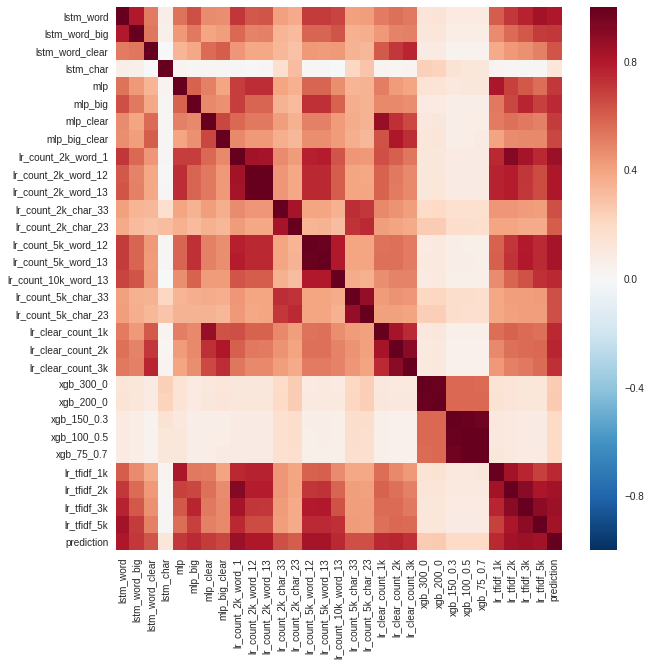

In [169]:
import seaborn as sns
plt.figure(figsize=(10, 10))
sns.heatmap(pr.corr())

### Metrics

In [237]:
from sklearn.metrics import auc, roc_curve, f1_score, confusion_matrix, roc_auc_score

In [186]:
pr.shape

(3547, 31)

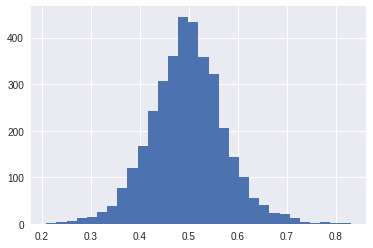

In [211]:
plt.hist(pr.prediction.values, bins=30);

In [171]:
accuracy_score(y_t, pr.prediction.values > 0.5)

0.56639413588948406

In [183]:
f1_score(y_t, pr.prediction.values > 0.4)

0.6374974442854221

In [189]:
# fpr, tpr = roc_curve(y_t, pr.drop('prediction', axis=1).values)
fpr, tpr, _ = roc_curve(y_t, pr.prediction.values)

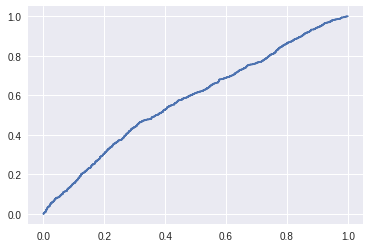

In [191]:
plt.plot(fpr, tpr)

In [192]:
auc(fpr, tpr)

0.58141052631578949

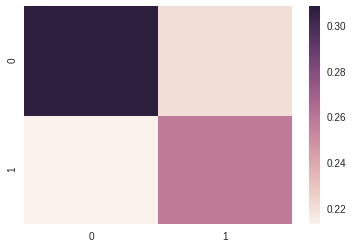

In [254]:
cm = confusion_matrix(y_t, (pr.prediction.values > 0.5).astype(int))
cm =  cm / cm.sum() #[np.newaxis]
sns.heatmap(cm)

### Selection model with l1 lr

In [255]:
lr = lm.LogisticRegression('l1', C=0.3)
lr.fit(pr.drop('prediction', axis=1).values, y_t)

LogisticRegression(C=0.3, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [256]:
sorted(list(zip(pr.columns[:-1], lr.coef_.ravel())), key=lambda x: x[1])

[('lstm_word', 0.0),
 ('lstm_word_big', 0.0),
 ('lstm_word_clear', 0.0),
 ('lstm_char', 0.0),
 ('mlp', 0.0),
 ('mlp_clear', 0.0),
 ('mlp_big_clear', 0.0),
 ('lr_count_2k_word_1', 0.0),
 ('lr_count_2k_word_13', 0.0),
 ('lr_count_2k_char_33', 0.0),
 ('lr_count_5k_word_13', 0.0),
 ('lr_count_10k_word_13', 0.0),
 ('lr_count_5k_char_23', 0.0),
 ('lr_clear_count_1k', 0.0),
 ('lr_clear_count_2k', 0.0),
 ('lr_clear_count_3k', 0.0),
 ('xgb_200_0', 0.0),
 ('xgb_150_0.3', 0.0),
 ('xgb_100_0.5', 0.0),
 ('xgb_75_0.7', 0.0),
 ('lr_tfidf_1k', 0.0),
 ('lr_tfidf_2k', 0.0),
 ('lr_tfidf_3k', 0.0),
 ('mlp_big', 0.079578809730879926),
 ('lr_tfidf_5k', 0.10877022807245063),
 ('xgb_300_0', 0.18565235883895151),
 ('lr_count_5k_word_12', 0.22940280716904571),
 ('lr_count_5k_char_33', 0.27444551864820244),
 ('lr_count_2k_word_12', 0.62057739526434041),
 ('lr_count_2k_char_23', 1.4703878156466577)]

In [257]:
best = list(filter(lambda x: x[1] != 0.0, zip(pr.columns[:-1], lr.coef_.ravel())))
best_model_names = [x[0] for x in best]

In [258]:
len(best)

7

In [259]:
accuracy_score(y_t, pr[best_model_names].mean(axis=1) > 0.5)

0.56216521003665065

In [260]:
roc_auc_score(y_t, pr[best_model_names].mean(axis=1))

0.58519362041467304

## Using best models

### Binary prediction

In [261]:
%%time
np.random.seed(0)
fit_predict_to_n_user(comments,
        [
            MlpModel('mlp_big', max_features=3000, neurons=700),
            LrModelTfidf('lr_tfidf_5k', 5000),
            FeaturesModelXGB('xgb_300_0', n_estimators=300, var_threshold=0.0),
            LrModelCount('lr_count_5k_word_12', 5000, ngram_range=(1, 2)),
            LrModelCount('lr_count_5k_char_33', 5000, 'char', (3, 3)),
            LrModelCount('lr_count_2k_word_12', 2000, ngram_range=(1, 2)),
            LrModelCount('lr_count_2k_char_23', 2000, 'char', (2, 3)),
        ], 11, False, with_additional=True, debug=True)

/home/digitman/miniconda3/lib/python3.6/site-packages/keras/activations.py:89: UserWarning: Do not pass a layer instance (such as PReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  ).format(identifier=identifier.__class__.__name__))


1429 - uniq peoples
4624 - additional peoples
Before sampling:
0.0    73488
1.0    54723
Name: is_gum, dtype: int64
Additional comments:
13244
Accuracy for comment:


/home/digitman/miniconda3/lib/python3.6/site-packages/keras/models.py:851: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Model:  mlp_big
0.540738652382
Model:  lr_tfidf_5k
0.539610938822
Model:  xgb_300_0
0.534254299408
Model:  lr_count_5k_word_12
0.544403721455
Model:  lr_count_5k_char_33
0.545531435016
Model:  lr_count_2k_word_12
0.551451931209
Model:  lr_count_2k_char_23
0.558218212574
Median of models: 0.558218212574
Accuracy for user:
Model:  mlp_big
0.559440559441
Model:  lr_tfidf_5k
0.615384615385
Model:  xgb_300_0
0.541958041958
Model:  lr_count_5k_word_12
0.618881118881
Model:  lr_count_5k_char_33
0.63986013986
Model:  lr_count_2k_word_12
0.65034965035
Model:  lr_count_2k_char_23
0.615384615385
Median of models averaged per user:
0.65034965035
Median of averaged model per user:
0.636363636364
CPU times: user 13min 9s, sys: 37 s, total: 13min 46s
Wall time: 5min 46s


### Probability prediction

In [262]:
%%time
np.random.seed(0)
fit_predict_to_n_user(comments,
        [
            MlpModel('mlp_big', max_features=3000, neurons=700),
            LrModelTfidf('lr_tfidf_5k', 5000),
            FeaturesModelXGB('xgb_300_0', n_estimators=300, var_threshold=0.0),
            LrModelCount('lr_count_5k_word_12', 5000, ngram_range=(1, 2)),
            LrModelCount('lr_count_5k_char_33', 5000, 'char', (3, 3)),
            LrModelCount('lr_count_2k_word_12', 2000, ngram_range=(1, 2)),
            LrModelCount('lr_count_2k_char_23', 2000, 'char', (2, 3)),
        ], 11, False, with_additional=True, debug=True, predict_proba=True)

/home/digitman/miniconda3/lib/python3.6/site-packages/keras/activations.py:89: UserWarning: Do not pass a layer instance (such as PReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  ).format(identifier=identifier.__class__.__name__))


1429 - uniq peoples
4624 - additional peoples
Before sampling:
0.0    73488
1.0    54723
Name: is_gum, dtype: int64
Additional comments:
13244
Accuracy for comment:


/home/digitman/miniconda3/lib/python3.6/site-packages/keras/models.py:851: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Model:  mlp_big
0.541020580772
Model:  lr_tfidf_5k
0.539610938822
Model:  xgb_300_0
0.534254299408
Model:  lr_count_5k_word_12
0.544403721455
Model:  lr_count_5k_char_33
0.545531435016
Model:  lr_count_2k_word_12
0.551451931209
Model:  lr_count_2k_char_23
0.558218212574
Mean of models: 0.558500140964
Accuracy for user:
Model:  mlp_big
0.632867132867
Model:  lr_tfidf_5k
0.597902097902
Model:  xgb_300_0
0.56993006993
Model:  lr_count_5k_word_12
0.629370629371
Model:  lr_count_5k_char_33
0.632867132867
Model:  lr_count_2k_word_12
0.65034965035
Model:  lr_count_2k_char_23
0.660839160839
Median of models averaged per user:
0.667832167832
Median of averaged model per user:
0.667832167832
CPU times: user 13min 16s, sys: 38.2 s, total: 13min 54s
Wall time: 5min 58s


Probability is better

## Predicting for one user in a wild

### AverageModel

In [294]:
class AverageModel():
    def __init__(self, models):
        self.models = models
        self._fitted = False
    
    def fit(self, X, y):
        for m in self.models:
            m.fit(X, y)
        self._fitted = True
    
    def predict(self, X):
        if not self._fitted:
            raise Exception('Not fitted yet')
        
        predictions = np.hstack([np.expand_dims(m.predict(X), -1) for m in self.models])
        predictions = (np.median(predictions, axis=1) > 0.5).astype(int)
        return predictions
    
    def predict_proba(self, X):
        if not self._fitted:
            raise Exception('Not fitted yet')
        
        predictions = []
        for model in self.models:
            prediction = model.predict_proba(X)
            if prediction.shape[1] > 1:
                prediction = prediction[:, 1]
            else:
                prediction = prediction.ravel()
            predictions.append(prediction)
                
        predictions = np.hstack([np.expand_dims(p, -1) for p in predictions])
        predictions = np.mean(predictions, axis=1)
        return predictions

In [320]:
av_model = AverageModel([
    MlpModel('mlp_big', max_features=3000, neurons=700),
    LrModelTfidf('lr_tfidf_5k', 5000),
    FeaturesModelXGB('xgb_300_0', n_estimators=300, var_threshold=0.0),
    LrModelCount('lr_count_5k_word_12', 5000, ngram_range=(1, 2)),
    LrModelCount('lr_count_5k_char_33', 5000, 'char', (3, 3)),
    LrModelCount('lr_count_2k_word_12', 2000, ngram_range=(1, 2)),
    LrModelCount('lr_count_2k_char_23', 2000, 'char', (2, 3)),
])

/home/digitman/miniconda3/lib/python3.6/site-packages/keras/activations.py:89: UserWarning: Do not pass a layer instance (such as PReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  ).format(identifier=identifier.__class__.__name__))


In [321]:
unique_ids = comments.from_id.value_counts()[comments.from_id.value_counts() >= 11].index.values
additional_ids = comments.from_id.value_counts()[comments.from_id.value_counts() < 11].index.values

train_idxs = unique_ids[:int(len(unique_ids) * 0.8)]
test_idxs = unique_ids[int(len(unique_ids) * 0.8):]

train_comments = comments[[i in train_idxs for i in comments.from_id]]
additional_comments = comments[[i in additional_ids for i in comments.from_id]]
train_comments = pd.concat((train_comments.reset_index(drop=True), additional_comments.reset_index(drop=True)))

test_comments = comments[[i in test_idxs for i in comments.from_id]]

train_comments = make_df_balanced(train_comments, 'is_gum')

X_train, X_test = train_comments, test_comments
y_train, y_test = train_comments.is_gum.values, test_comments.is_gum.values

In [ ]:
av_model.fit(X_train, y_train)

/home/digitman/miniconda3/lib/python3.6/site-packages/keras/models.py:851: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


In [ ]:
pr = av_model.predict(X_test)

In [299]:
accuracy_score(y_test, pr)

0.57287848886382864

In [ ]:
accuracy_score(y_test, pr)

In [ ]:
pr = av_model.predict_proba(X_test)

In [301]:
accuracy_score(y_test, pr > 0.5)

0.55821821257400617

In [ ]:
accuracy_score(y_test, pr > 0.5)

In [303]:
my_coms = ['Эй ты а ну быро отошел от моей машины!!!',
           'Вчера на вогресе такую аварию видел',
           'Слышали, проезд до 17р подорожал?)']

In [305]:
my_coms_df = pd.DataFrame(my_coms, columns=['text'])

In [308]:
av_model.predict(my_coms_df)

array([0, 0, 0])

In [ ]:
av_model.predict(my_coms_df)

In [309]:
av_model.predict_proba(my_coms_df)

array([ 0.52132869,  0.43700393,  0.39854874])

In [ ]:
av_model.predict_proba(my_coms_df)

In [319]:
%time prob = av_model.predict_proba(my_coms_df).mean()

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 3.75 ms


In [312]:
print('Ваша оценка: {:.2f}'.format(prob))

Ваша оценка: 0.45


.6536
.6398

### For different n

In [150]:
%%time
np.random.seed(0)
scores = []
for i in range(1, 21):
    sc = fit_predict_to_n_user(comments,
            [
                LstmModel('lstm_word', nb_epoch=5),
    #             LstmModel('lstm_char', nb_epoch=5, nb_words=100, char_level=True, max_len=100),
                MlpModel('mlp'),
                LrModelCount('lr_count_2k_word', 2000, ngram_range=(1, 2)),
                LrModelCount('lr_count_2k_char', 2000, 'char', (3, 3)),
                LrModelCount('lr_count_5k_word', 5000, ngram_range=(1, 2)),
                LrModelCount('lr_count_5k_char', 5000, 'char', (3, 3)),

                LrModelCountClear('lr_clear_count_1k', 1000),
                FeaturesModelXGB('xgb'),
                LrModelTfidf('lr_tfidf_1k', 1000),
                LrModelTfidf('lr_tfidf_5k', 5000),
            ], i, False, with_additional=True, debug=False)
    scores.append(sc)

/home/digitman/miniconda3/lib/python3.6/site-packages/keras/preprocessing/text.py:90: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '
/home/digitman/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)`
/home/digitman/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, return_sequences=False, dropout=0.3, recurrent_dropout=0.3)`
/home/digitman/miniconda3/lib/python3.6/site-packages/keras/activations.py:89: UserWarning: Do not pass a layer instance (such as PReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  ).format(identifier=identifier.__class__.__name__))


Accuracy for comment:


/home/digitman/miniconda3/lib/python3.6/site-packages/keras/models.py:851: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Model:  lstm_word
0.505617977528
Model:  mlp
0.512172284644
Model:  lr_count_2k_word
0.507490636704
Model:  lr_count_2k_char
0.526217228464
Model:  lr_count_5k_word
0.503745318352
Model:  lr_count_5k_char
0.50468164794
Model:  lr_clear_count_1k
0.5234082397
Model:  xgb
0.52808988764
Model:  lr_tfidf_1k
0.50936329588
Model:  lr_tfidf_5k
0.507490636704
Median of models: 0.520599250936
Accuracy for user:
Model:  lstm_word
0.505617977528
Model:  mlp
0.512172284644
Model:  lr_count_2k_word
0.507490636704
Model:  lr_count_2k_char
0.526217228464
Model:  lr_count_5k_word
0.503745318352
Model:  lr_count_5k_char
0.50468164794
Model:  lr_clear_count_1k
0.5234082397
Model:  xgb
0.52808988764
Model:  lr_tfidf_1k
0.50936329588
Model:  lr_tfidf_5k
0.507490636704
Median of models averaged per user:
0.520599250936

/home/digitman/miniconda3/lib/python3.6/site-packages/keras/preprocessing/text.py:90: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '
/home/digitman/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)`
/home/digitman/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, return_sequences=False, dropout=0.3, recurrent_dropout=0.3)`
/home/digitman/miniconda3/lib/python3.6/site-packages/keras/activations.py:89: UserWarning: Do not pass a layer instance (such as PReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  ).format(identifier=identifier.__class__.__name__))



Median of averaged model per user:
0.520599250936
Accuracy for comment:


/home/digitman/miniconda3/lib/python3.6/site-packages/keras/models.py:851: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Model:  lstm_word
0.495670995671
Model:  mlp
0.50937950938
Model:  lr_count_2k_word
0.502886002886
Model:  lr_count_2k_char
0.510101010101
Model:  lr_count_5k_word
0.517316017316
Model:  lr_count_5k_char
0.507936507937
Model:  lr_clear_count_1k
0.511544011544
Model:  xgb
0.48556998557
Model:  lr_tfidf_1k
0.510822510823
Model:  lr_tfidf_5k
0.510101010101
Median of models: 0.512987012987
Accuracy for user:
Model:  lstm_word
0.507936507937
Model:  mlp
0.506493506494
Model:  lr_count_2k_word
0.507936507937
Model:  lr_count_2k_char
0.518037518038
Model:  lr_count_5k_word
0.519480519481
Model:  lr_count_5k_char
0.503607503608
Model:  lr_clear_count_1k
0.525252525253
Model:  xgb
0.496392496392
Model:  lr_tfidf_1k
0.513708513709
Model:  lr_tfidf_5k
0.518037518038
Median of models averaged per user:
0.515151515152
Median of averaged model per user:
0.52380952381


/home/digitman/miniconda3/lib/python3.6/site-packages/keras/preprocessing/text.py:90: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '
/home/digitman/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)`
/home/digitman/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, return_sequences=False, dropout=0.3, recurrent_dropout=0.3)`
/home/digitman/miniconda3/lib/python3.6/site-packages/keras/activations.py:89: UserWarning: Do not pass a layer instance (such as PReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  ).format(identifier=identifier.__class__.__name__))


Accuracy for comment:


/home/digitman/miniconda3/lib/python3.6/site-packages/keras/models.py:851: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Model:  lstm_word
0.514167650531
Model:  mlp
0.512396694215
Model:  lr_count_2k_word
0.511806375443
Model:  lr_count_2k_char
0.513577331759
Model:  lr_count_5k_word
0.517709563164
Model:  lr_count_5k_char
0.499409681228
Model:  lr_clear_count_1k
0.524203069658
Model:  xgb
0.510625737898
Model:  lr_tfidf_1k
0.507674144038
Model:  lr_tfidf_5k
0.514167650531
Median of models: 0.512987012987
Accuracy for user:
Model:  lstm_word
0.534709193246
Model:  mlp
0.527204502814
Model:  lr_count_2k_word
0.544090056285
Model:  lr_count_2k_char
0.527204502814
Model:  lr_count_5k_word
0.527204502814
Model:  lr_count_5k_char
0.512195121951
Model:  lr_clear_count_1k
0.538461538462
Model:  xgb
0.519699812383
Model:  lr_tfidf_1k
0.519699812383
Model:  lr_tfidf_5k
0.538461538462
Median of models averaged per user:
0.544090056285
Median of averaged model per user:
0.53095684803


/home/digitman/miniconda3/lib/python3.6/site-packages/keras/preprocessing/text.py:90: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '
/home/digitman/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)`
/home/digitman/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, return_sequences=False, dropout=0.3, recurrent_dropout=0.3)`
/home/digitman/miniconda3/lib/python3.6/site-packages/keras/activations.py:89: UserWarning: Do not pass a layer instance (such as PReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  ).format(identifier=identifier.__class__.__name__))


Accuracy for comment:


/home/digitman/miniconda3/lib/python3.6/site-packages/keras/models.py:851: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Model:  lstm_word
0.510660426417
Model:  mlp
0.515860634425
Model:  lr_count_2k_word
0.527301092044
Model:  lr_count_2k_char
0.519500780031
Model:  lr_count_5k_word
0.519500780031
Model:  lr_count_5k_char
0.509100364015
Model:  lr_clear_count_1k
0.520540821633
Model:  xgb
0.527301092044
Model:  lr_tfidf_1k
0.50598023921
Model:  lr_tfidf_5k
0.515340613625
Median of models: 0.525741029641
Accuracy for user:
Model:  lstm_word
0.512359550562
Model:  mlp
0.52808988764
Model:  lr_count_2k_word
0.54606741573
Model:  lr_count_2k_char
0.525842696629
Model:  lr_count_5k_word
0.54606741573
Model:  lr_count_5k_char
0.516853932584
Model:  lr_clear_count_1k
0.54606741573
Model:  xgb
0.539325842697
Model:  lr_tfidf_1k
0.521348314607
Model:  lr_tfidf_5k
0.539325842697
Median of models averaged per user:
0.54606741573
Median of averaged model per user:
0.539325842697

/home/digitman/miniconda3/lib/python3.6/site-packages/keras/preprocessing/text.py:90: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '
/home/digitman/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)`
/home/digitman/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, return_sequences=False, dropout=0.3, recurrent_dropout=0.3)`
/home/digitman/miniconda3/lib/python3.6/site-packages/keras/activations.py:89: UserWarning: Do not pass a layer instance (such as PReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  ).format(identifier=identifier.__class__.__name__))



Accuracy for comment:


/home/digitman/miniconda3/lib/python3.6/site-packages/keras/models.py:851: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Model:  lstm_word
0.51395572666
Model:  mlp
0.523580365736
Model:  lr_count_2k_word
0.52021174206
Model:  lr_count_2k_char
0.51010587103
Model:  lr_count_5k_word
0.521174205967
Model:  lr_count_5k_char
0.507218479307
Model:  lr_clear_count_1k
0.518768046198
Model:  xgb
0.523099133782
Model:  lr_tfidf_1k
0.510587102984
Model:  lr_tfidf_5k
0.519249278152
Median of models: 0.533205004812
Accuracy for user:
Model:  lstm_word
0.537662337662
Model:  mlp
0.532467532468
Model:  lr_count_2k_word
0.527272727273
Model:  lr_count_2k_char
0.503896103896
Model:  lr_count_5k_word
0.548051948052
Model:  lr_count_5k_char
0.509090909091
Model:  lr_clear_count_1k
0.535064935065
Model:  xgb
0.550649350649
Model:  lr_tfidf_1k
0.501298701299
Model:  lr_tfidf_5k
0.532467532468
Median of models averaged per user:
0.537662337662
Median of averaged model per user:
0.568831168831


/home/digitman/miniconda3/lib/python3.6/site-packages/keras/preprocessing/text.py:90: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '
/home/digitman/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)`
/home/digitman/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, return_sequences=False, dropout=0.3, recurrent_dropout=0.3)`
/home/digitman/miniconda3/lib/python3.6/site-packages/keras/activations.py:89: UserWarning: Do not pass a layer instance (such as PReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  ).format(identifier=identifier.__class__.__name__))


Accuracy for comment:


/home/digitman/miniconda3/lib/python3.6/site-packages/keras/models.py:851: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Model:  lstm_word
0.51912568306
Model:  mlp
0.511839708561
Model:  lr_count_2k_word
0.516848816029
Model:  lr_count_2k_char
0.517304189435
Model:  lr_count_5k_word
0.524590163934
Model:  lr_count_5k_char
0.508652094718
Model:  lr_clear_count_1k
0.52276867031
Model:  xgb
0.509107468124
Model:  lr_tfidf_1k
0.516848816029
Model:  lr_tfidf_5k
0.530054644809
Median of models: 0.525500910747
Accuracy for user:
Model:  lstm_word
0.523668639053
Model:  mlp
0.479289940828
Model:  lr_count_2k_word
0.526627218935
Model:  lr_count_2k_char
0.508875739645
Model:  lr_count_5k_word
0.529585798817
Model:  lr_count_5k_char
0.508875739645
Model:  lr_clear_count_1k
0.511834319527
Model:  xgb
0.511834319527
Model:  lr_tfidf_1k
0.5
Model:  lr_tfidf_5k
0.532544378698
Median of models averaged per user:
0.529585798817


/home/digitman/miniconda3/lib/python3.6/site-packages/keras/preprocessing/text.py:90: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '
/home/digitman/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)`
/home/digitman/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, return_sequences=False, dropout=0.3, recurrent_dropout=0.3)`
/home/digitman/miniconda3/lib/python3.6/site-packages/keras/activations.py:89: UserWarning: Do not pass a layer instance (such as PReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  ).format(identifier=identifier.__class__.__name__))


Median of averaged model per user:
0.532544378698
Accuracy for comment:


/home/digitman/miniconda3/lib/python3.6/site-packages/keras/models.py:851: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Model:  lstm_word
0.517346053773
Model:  mlp
0.50607111882
Model:  lr_count_2k_word
0.514744145707
Model:  lr_count_2k_char
0.501734605377
Model:  lr_count_5k_word
0.510407632264
Model:  lr_count_5k_char
0.508673026886
Model:  lr_clear_count_1k
0.518213356461
Model:  xgb
0.510841283608
Model:  lr_tfidf_1k
0.511274934952
Model:  lr_tfidf_5k
0.511274934952
Median of models: 0.512142237641
Accuracy for user:
Model:  lstm_word
0.543046357616
Model:  mlp
0.5
Model:  lr_count_2k_word
0.543046357616
Model:  lr_count_2k_char
0.523178807947
Model:  lr_count_5k_word
0.513245033113
Model:  lr_count_5k_char
0.493377483444
Model:  lr_clear_count_1k
0.513245033113
Model:  xgb
0.539735099338
Model:  lr_tfidf_1k
0.513245033113
Model:  lr_tfidf_5k
0.523178807947
Median of models averaged per user:
0.53642384106
Median of averaged model per user:
0.529801324503


/home/digitman/miniconda3/lib/python3.6/site-packages/keras/preprocessing/text.py:90: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '
/home/digitman/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)`
/home/digitman/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, return_sequences=False, dropout=0.3, recurrent_dropout=0.3)`
/home/digitman/miniconda3/lib/python3.6/site-packages/keras/activations.py:89: UserWarning: Do not pass a layer instance (such as PReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  ).format(identifier=identifier.__class__.__name__))


Accuracy for comment:


/home/digitman/miniconda3/lib/python3.6/site-packages/keras/models.py:851: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Model:  lstm_word
0.520403870425
Model:  mlp
0.518300378629
Model:  lr_count_2k_word
0.525872949095
Model:  lr_count_2k_char
0.517038283551
Model:  lr_count_5k_word
0.521245267143
Model:  lr_count_5k_char
0.528397139251
Model:  lr_clear_count_1k
0.535128313
Model:  xgb
0.514093395036
Model:  lr_tfidf_1k
0.523769457299
Model:  lr_tfidf_5k
0.519562473706
Median of models: 0.533866217922
Accuracy for user:
Model:  lstm_word
0.553113553114
Model:  mlp
0.556776556777
Model:  lr_count_2k_word
0.534798534799
Model:  lr_count_2k_char
0.542124542125
Model:  lr_count_5k_word
0.556776556777
Model:  lr_count_5k_char
0.531135531136
Model:  lr_clear_count_1k
0.586080586081
Model:  xgb
0.520146520147
Model:  lr_tfidf_1k
0.534798534799
Model:  lr_tfidf_5k
0.538461538462
Median of models averaged per user:
0.56043956044
Median of averaged model per user:
0.564102564103


/home/digitman/miniconda3/lib/python3.6/site-packages/keras/preprocessing/text.py:90: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '
/home/digitman/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)`
/home/digitman/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, return_sequences=False, dropout=0.3, recurrent_dropout=0.3)`
/home/digitman/miniconda3/lib/python3.6/site-packages/keras/activations.py:89: UserWarning: Do not pass a layer instance (such as PReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  ).format(identifier=identifier.__class__.__name__))


Accuracy for comment:


/home/digitman/miniconda3/lib/python3.6/site-packages/keras/models.py:851: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Model:  lstm_word
0.534201954397
Model:  mlp
0.532980456026
Model:  lr_count_2k_word
0.54845276873
Model:  lr_count_2k_char
0.53664495114
Model:  lr_count_5k_word
0.541123778502
Model:  lr_count_5k_char
0.545195439739
Model:  lr_clear_count_1k
0.538680781759
Model:  xgb
0.510586319218
Model:  lr_tfidf_1k
0.541123778502
Model:  lr_tfidf_5k
0.53664495114
Median of models: 0.550895765472
Accuracy for user:
Model:  lstm_word
0.560483870968
Model:  mlp
0.552419354839
Model:  lr_count_2k_word
0.620967741935
Model:  lr_count_2k_char
0.564516129032
Model:  lr_count_5k_word
0.588709677419
Model:  lr_count_5k_char
0.58064516129
Model:  lr_clear_count_1k
0.58064516129
Model:  xgb
0.495967741935
Model:  lr_tfidf_1k
0.568548387097
Model:  lr_tfidf_5k
0.560483870968
Median of models averaged per user:
0.584677419355


/home/digitman/miniconda3/lib/python3.6/site-packages/keras/preprocessing/text.py:90: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '
/home/digitman/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)`
/home/digitman/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, return_sequences=False, dropout=0.3, recurrent_dropout=0.3)`
/home/digitman/miniconda3/lib/python3.6/site-packages/keras/activations.py:89: UserWarning: Do not pass a layer instance (such as PReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  ).format(identifier=identifier.__class__.__name__))


Median of averaged model per user:
0.58064516129
Accuracy for comment:


/home/digitman/miniconda3/lib/python3.6/site-packages/keras/models.py:851: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Model:  lstm_word
0.522500995619
Model:  mlp
0.52608522501
Model:  lr_count_2k_word
0.52528872959
Model:  lr_count_2k_char
0.539625647153
Model:  lr_count_5k_word
0.529271206691
Model:  lr_count_5k_char
0.536041417762
Model:  lr_clear_count_1k
0.532058940661
Model:  xgb
0.534050179211
Model:  lr_tfidf_1k
0.533253683791
Model:  lr_tfidf_5k
0.543608124253
Median of models: 0.544404619673
Accuracy for user:
Model:  lstm_word
0.561403508772
Model:  mlp
0.565789473684
Model:  lr_count_2k_word
0.570175438596
Model:  lr_count_2k_char
0.578947368421
Model:  lr_count_5k_word
0.561403508772
Model:  lr_count_5k_char
0.583333333333
Model:  lr_clear_count_1k
0.539473684211
Model:  xgb
0.539473684211
Model:  lr_tfidf_1k
0.614035087719
Model:  lr_tfidf_5k
0.570175438596
Median of models averaged per user:
0.565789473684
Median of averaged model per user:
0.561403508772


/home/digitman/miniconda3/lib/python3.6/site-packages/keras/preprocessing/text.py:90: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '
/home/digitman/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)`
/home/digitman/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, return_sequences=False, dropout=0.3, recurrent_dropout=0.3)`
/home/digitman/miniconda3/lib/python3.6/site-packages/keras/activations.py:89: UserWarning: Do not pass a layer instance (such as PReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  ).format(identifier=identifier.__class__.__name__))


Accuracy for comment:


/home/digitman/miniconda3/lib/python3.6/site-packages/keras/models.py:851: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Model:  lstm_word
0.511655011655
Model:  mlp
0.51825951826
Model:  lr_count_2k_word
0.520590520591
Model:  lr_count_2k_char
0.532634032634
Model:  lr_count_5k_word
0.53108003108
Model:  lr_count_5k_char
0.530303030303
Model:  lr_clear_count_1k
0.52602952603
Model:  xgb
0.52602952603
Model:  lr_tfidf_1k
0.530303030303
Model:  lr_tfidf_5k
0.538461538462
Median of models: 0.533411033411
Accuracy for user:
Model:  lstm_word
0.509433962264
Model:  mlp
0.580188679245
Model:  lr_count_2k_word
0.556603773585
Model:  lr_count_2k_char
0.575471698113
Model:  lr_count_5k_word
0.589622641509
Model:  lr_count_5k_char
0.561320754717
Model:  lr_clear_count_1k
0.547169811321
Model:  xgb
0.556603773585
Model:  lr_tfidf_1k
0.584905660377
Model:  lr_tfidf_5k
0.580188679245
Median of models averaged per user:
0.575471698113
Median of averaged model per user:
0.580188679245


/home/digitman/miniconda3/lib/python3.6/site-packages/keras/preprocessing/text.py:90: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '
/home/digitman/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)`
/home/digitman/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, return_sequences=False, dropout=0.3, recurrent_dropout=0.3)`
/home/digitman/miniconda3/lib/python3.6/site-packages/keras/activations.py:89: UserWarning: Do not pass a layer instance (such as PReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  ).format(identifier=identifier.__class__.__name__))


Accuracy for comment:


/home/digitman/miniconda3/lib/python3.6/site-packages/keras/models.py:851: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Model:  lstm_word
0.506717850288
Model:  mlp
0.516314779271
Model:  lr_count_2k_word
0.520537428023
Model:  lr_count_2k_char
0.528598848369
Model:  lr_count_5k_word
0.525143953935
Model:  lr_count_5k_char
0.532821497121
Model:  lr_clear_count_1k
0.529366602687
Model:  xgb
0.518618042226
Model:  lr_tfidf_1k
0.521689059501
Model:  lr_tfidf_5k
0.52207293666
Median of models: 0.523992322457
Accuracy for user:
Model:  lstm_word
0.492462311558
Model:  mlp
0.537688442211
Model:  lr_count_2k_word
0.547738693467
Model:  lr_count_2k_char
0.592964824121
Model:  lr_count_5k_word
0.56783919598
Model:  lr_count_5k_char
0.587939698492
Model:  lr_clear_count_1k
0.562814070352
Model:  xgb
0.562814070352
Model:  lr_tfidf_1k
0.547738693467
Model:  lr_tfidf_5k
0.572864321608
Median of models averaged per user:
0.582914572864
Median of averaged model per user:

/home/digitman/miniconda3/lib/python3.6/site-packages/keras/preprocessing/text.py:90: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '
/home/digitman/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)`
/home/digitman/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, return_sequences=False, dropout=0.3, recurrent_dropout=0.3)`
/home/digitman/miniconda3/lib/python3.6/site-packages/keras/activations.py:89: UserWarning: Do not pass a layer instance (such as PReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  ).format(identifier=identifier.__class__.__name__))



0.552763819095
Accuracy for comment:


/home/digitman/miniconda3/lib/python3.6/site-packages/keras/models.py:851: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Model:  lstm_word
0.501131221719
Model:  mlp
0.519230769231
Model:  lr_count_2k_word
0.510935143288
Model:  lr_count_2k_char
0.525641025641
Model:  lr_count_5k_word
0.50754147813
Model:  lr_count_5k_char
0.522247360483
Model:  lr_clear_count_1k
0.524509803922
Model:  xgb
0.505279034691
Model:  lr_tfidf_1k
0.519230769231
Model:  lr_tfidf_5k
0.530165912519
Median of models: 0.523755656109
Accuracy for user:
Model:  lstm_word
0.532608695652
Model:  mlp
0.548913043478
Model:  lr_count_2k_word
0.559782608696
Model:  lr_count_2k_char
0.576086956522
Model:  lr_count_5k_word
0.5
Model:  lr_count_5k_char
0.586956521739
Model:  lr_clear_count_1k
0.570652173913
Model:  xgb
0.5
Model:  lr_tfidf_1k
0.538043478261
Model:  lr_tfidf_5k
0.586956521739
Median of models averaged per user:
0.565217391304


/home/digitman/miniconda3/lib/python3.6/site-packages/keras/preprocessing/text.py:90: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '
/home/digitman/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)`
/home/digitman/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, return_sequences=False, dropout=0.3, recurrent_dropout=0.3)`
/home/digitman/miniconda3/lib/python3.6/site-packages/keras/activations.py:89: UserWarning: Do not pass a layer instance (such as PReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  ).format(identifier=identifier.__class__.__name__))


Median of averaged model per user:
0.559782608696
Accuracy for comment:


/home/digitman/miniconda3/lib/python3.6/site-packages/keras/models.py:851: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Model:  lstm_word
0.518449496832
Model:  mlp
0.530003727171
Model:  lr_count_2k_word
0.52851285874
Model:  lr_count_2k_char
0.529258292956
Model:  lr_count_5k_word
0.530376444279
Model:  lr_count_5k_char
0.525903838986
Model:  lr_clear_count_1k
0.540439806187
Model:  xgb
0.519567648155
Model:  lr_tfidf_1k
0.532985464033
Model:  lr_tfidf_5k
0.540812523295
Median of models: 0.537830786433
Accuracy for user:
Model:  lstm_word
0.563218390805
Model:  mlp
0.586206896552
Model:  lr_count_2k_word
0.568965517241
Model:  lr_count_2k_char
0.563218390805
Model:  lr_count_5k_word
0.591954022989
Model:  lr_count_5k_char
0.586206896552
Model:  lr_clear_count_1k
0.620689655172
Model:  xgb
0.557471264368
Model:  lr_tfidf_1k
0.591954022989
Model:  lr_tfidf_5k
0.649425287356
Median of models averaged per user:
0.609195402299
Median of averaged model per user:
0.586206896552


/home/digitman/miniconda3/lib/python3.6/site-packages/keras/preprocessing/text.py:90: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '
/home/digitman/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)`
/home/digitman/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, return_sequences=False, dropout=0.3, recurrent_dropout=0.3)`
/home/digitman/miniconda3/lib/python3.6/site-packages/keras/activations.py:89: UserWarning: Do not pass a layer instance (such as PReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  ).format(identifier=identifier.__class__.__name__))


Accuracy for comment:


/home/digitman/miniconda3/lib/python3.6/site-packages/keras/models.py:851: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Model:  lstm_word
0.513114148504
Model:  mlp
0.52124122645
Model:  lr_count_2k_word
0.516808274843
Model:  lr_count_2k_char
0.511636497968
Model:  lr_count_5k_word
0.5108976727
Model:  lr_count_5k_char
0.508681196897
Model:  lr_clear_count_1k
0.530476542298
Model:  xgb
0.530107129664
Model:  lr_tfidf_1k
0.515700036941
Model:  lr_tfidf_5k
0.530845954932
Median of models: 0.525304765423
Accuracy for user:
Model:  lstm_word
0.493902439024
Model:  mlp
0.55487804878
Model:  lr_count_2k_word
0.536585365854
Model:  lr_count_2k_char
0.506097560976
Model:  lr_count_5k_word
0.512195121951
Model:  lr_count_5k_char
0.536585365854
Model:  lr_clear_count_1k
0.59756097561
Model:  xgb
0.585365853659
Model:  lr_tfidf_1k
0.524390243902
Model:  lr_tfidf_5k
0.591463414634
Median of models averaged per user:
0.548780487805
Median of averaged model per user:
0.542682926829


/home/digitman/miniconda3/lib/python3.6/site-packages/keras/preprocessing/text.py:90: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '
/home/digitman/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)`
/home/digitman/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, return_sequences=False, dropout=0.3, recurrent_dropout=0.3)`
/home/digitman/miniconda3/lib/python3.6/site-packages/keras/activations.py:89: UserWarning: Do not pass a layer instance (such as PReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  ).format(identifier=identifier.__class__.__name__))


Accuracy for comment:


/home/digitman/miniconda3/lib/python3.6/site-packages/keras/models.py:851: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Model:  lstm_word
0.507262164125
Model:  mlp
0.518518518519
Model:  lr_count_2k_word
0.515250544662
Model:  lr_count_2k_char
0.512708787219
Model:  lr_count_5k_word
0.509077705156
Model:  lr_count_5k_char
0.5174291939
Model:  lr_clear_count_1k
0.536310820625
Model:  xgb
0.5232389252
Model:  lr_tfidf_1k
0.518881626725
Model:  lr_tfidf_5k
0.533042846768
Median of models: 0.532679738562
Accuracy for user:
Model:  lstm_word
0.532467532468
Model:  mlp
0.551948051948
Model:  lr_count_2k_word
0.545454545455
Model:  lr_count_2k_char
0.519480519481
Model:  lr_count_5k_word
0.525974025974
Model:  lr_count_5k_char
0.545454545455
Model:  lr_clear_count_1k
0.597402597403
Model:  xgb
0.545454545455
Model:  lr_tfidf_1k
0.551948051948
Model:  lr_tfidf_5k
0.603896103896
Median of models averaged per user:
0.564935064935
Median of averaged model per user:

/home/digitman/miniconda3/lib/python3.6/site-packages/keras/preprocessing/text.py:90: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '
/home/digitman/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)`
/home/digitman/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, return_sequences=False, dropout=0.3, recurrent_dropout=0.3)`
/home/digitman/miniconda3/lib/python3.6/site-packages/keras/activations.py:89: UserWarning: Do not pass a layer instance (such as PReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  ).format(identifier=identifier.__class__.__name__))



0.558441558442
Accuracy for comment:


/home/digitman/miniconda3/lib/python3.6/site-packages/keras/models.py:851: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Model:  lstm_word
0.51570964247
Model:  mlp
0.534850126399
Model:  lr_count_2k_word
0.52618273745
Model:  lr_count_2k_char
0.520765619357
Model:  lr_count_5k_word
0.534488985193
Model:  lr_count_5k_char
0.526905019863
Model:  lr_clear_count_1k
0.547128927411
Model:  xgb
0.513542795233
Model:  lr_tfidf_1k
0.5290718671
Model:  lr_tfidf_5k
0.526905019863
Median of models: 0.533044420368
Accuracy for user:
Model:  lstm_word
0.493243243243
Model:  mlp
0.587837837838
Model:  lr_count_2k_word
0.560810810811
Model:  lr_count_2k_char
0.533783783784
Model:  lr_count_5k_word
0.641891891892
Model:  lr_count_5k_char
0.560810810811
Model:  lr_clear_count_1k
0.608108108108
Model:  xgb
0.513513513514
Model:  lr_tfidf_1k
0.533783783784
Model:  lr_tfidf_5k
0.587837837838
Median of models averaged per user:
0.560810810811
Median of averaged model per user:


/home/digitman/miniconda3/lib/python3.6/site-packages/keras/preprocessing/text.py:90: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '
/home/digitman/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)`
/home/digitman/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, return_sequences=False, dropout=0.3, recurrent_dropout=0.3)`
/home/digitman/miniconda3/lib/python3.6/site-packages/keras/activations.py:89: UserWarning: Do not pass a layer instance (such as PReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  ).format(identifier=identifier.__class__.__name__))


0.574324324324
Accuracy for comment:


/home/digitman/miniconda3/lib/python3.6/site-packages/keras/models.py:851: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Model:  lstm_word
0.515873015873
Model:  mlp
0.505050505051
Model:  lr_count_2k_word
0.513347763348
Model:  lr_count_2k_char
0.506854256854
Model:  lr_count_5k_word
0.511904761905
Model:  lr_count_5k_char
0.516955266955
Model:  lr_clear_count_1k
0.532467532468
Model:  xgb
0.498917748918
Model:  lr_tfidf_1k
0.520923520924
Model:  lr_tfidf_5k
0.521645021645
Median of models: 0.522727272727
Accuracy for user:
Model:  lstm_word
0.528571428571
Model:  mlp
0.514285714286
Model:  lr_count_2k_word
0.514285714286
Model:  lr_count_2k_char
0.478571428571
Model:  lr_count_5k_word
0.5
Model:  lr_count_5k_char
0.542857142857
Model:  lr_clear_count_1k
0.571428571429
Model:  xgb
0.507142857143
Model:  lr_tfidf_1k
0.542857142857
Model:  lr_tfidf_5k
0.592857142857
Median of models averaged per user:
0.535714285714
Median of averaged model per user:
0.55


/home/digitman/miniconda3/lib/python3.6/site-packages/keras/preprocessing/text.py:90: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '
/home/digitman/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)`
/home/digitman/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, return_sequences=False, dropout=0.3, recurrent_dropout=0.3)`
/home/digitman/miniconda3/lib/python3.6/site-packages/keras/activations.py:89: UserWarning: Do not pass a layer instance (such as PReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  ).format(identifier=identifier.__class__.__name__))


Accuracy for comment:


/home/digitman/miniconda3/lib/python3.6/site-packages/keras/models.py:851: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Model:  lstm_word
0.534958766583
Model:  mlp
0.53101470061
Model:  lr_count_2k_word
0.525636428828
Model:  lr_count_2k_char
0.524202223019
Model:  lr_count_5k_word
0.537110075296
Model:  lr_count_5k_char
0.53280745787
Model:  lr_clear_count_1k
0.533166009322
Model:  xgb
0.502330584439
Model:  lr_tfidf_1k
0.537110075296
Model:  lr_tfidf_5k
0.528863391897
Median of models: 0.539261384009
Accuracy for user:
Model:  lstm_word
0.626865671642
Model:  mlp
0.544776119403
Model:  lr_count_2k_word
0.574626865672
Model:  lr_count_2k_char
0.559701492537
Model:  lr_count_5k_word
0.65671641791
Model:  lr_count_5k_char
0.626865671642
Model:  lr_clear_count_1k
0.611940298507
Model:  xgb
0.5
Model:  lr_tfidf_1k
0.582089552239
Model:  lr_tfidf_5k
0.589552238806
Median of models averaged per user:
0.60447761194
Median of averaged model per user:
0.574626865672


/home/digitman/miniconda3/lib/python3.6/site-packages/keras/preprocessing/text.py:90: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '
/home/digitman/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)`
/home/digitman/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, return_sequences=False, dropout=0.3, recurrent_dropout=0.3)`
/home/digitman/miniconda3/lib/python3.6/site-packages/keras/activations.py:89: UserWarning: Do not pass a layer instance (such as PReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  ).format(identifier=identifier.__class__.__name__))


Accuracy for comment:


/home/digitman/miniconda3/lib/python3.6/site-packages/keras/models.py:851: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Model:  lstm_word
0.519285714286
Model:  mlp
0.526785714286
Model:  lr_count_2k_word
0.524285714286
Model:  lr_count_2k_char
0.53
Model:  lr_count_5k_word
0.531071428571
Model:  lr_count_5k_char
0.532857142857
Model:  lr_clear_count_1k
0.530714285714
Model:  xgb
0.493214285714
Model:  lr_tfidf_1k
0.529642857143
Model:  lr_tfidf_5k
0.53
Median of models: 0.533571428571
Accuracy for user:
Model:  lstm_word
0.546875
Model:  mlp
0.609375
Model:  lr_count_2k_word
0.578125
Model:  lr_count_2k_char
0.5703125
Model:  lr_count_5k_word
0.6171875
Model:  lr_count_5k_char
0.5703125
Model:  lr_clear_count_1k
0.5859375
Model:  xgb
0.5
Model:  lr_tfidf_1k
0.609375
Model:  lr_tfidf_5k
0.546875
Median of models averaged per user:
0.609375
Median of averaged model per user:
0.609375
CPU times: user 18h 3min 49s, sys: 1h 44min 33s, total: 19h 48min 23s
Wall time: 5h 49min 51s


In [151]:
%matplotlib inline

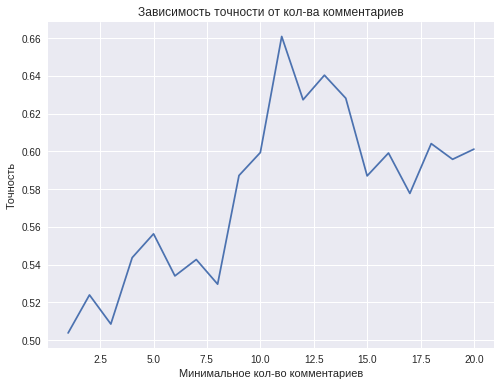

In [265]:
fig = plt.figure(figsize=(8, 6))

plt.plot(range(1, 21), [x[1] for x in scores])
# plt.plot(range(3, 21), [x[1] for x in scores])
# plt.yticks(np.round(np.linspace(0.51, 0.66, 16), 2));
# plt.xticks(np.linspace(0, 16, 17));
# plt.ylim(0.51, 0.66)
# plt.xlim(0, 16)
plt.xlabel('Минимальное кол-во комментариев')
plt.ylabel('Точность')
plt.title('Зависимость точности от кол-ва комментариев');

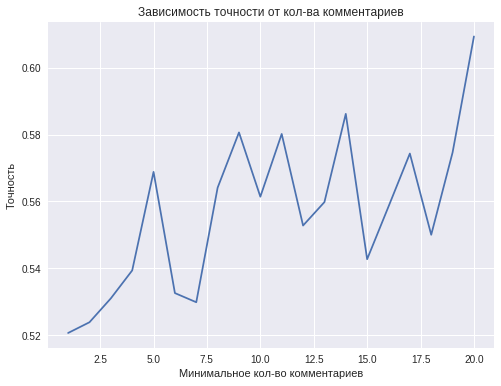

In [152]:
fig = plt.figure(figsize=(8, 6))

plt.plot(range(1, 21), [x[1] for x in scores])
# plt.plot(range(3, 21), [x[1] for x in scores])
# plt.yticks(np.round(np.linspace(0.51, 0.66, 16), 2));
# plt.xticks(np.linspace(0, 16, 17));
# plt.ylim(0.51, 0.66)
# plt.xlim(0, 16)
plt.xlabel('Минимальное кол-во комментариев')
plt.ylabel('Точность')
plt.title('Зависимость точности от кол-ва комментариев');

In [153]:
fig.savefig('temp2.png')

In [267]:
uniq_ids = []
for i in range(1, 21):
    unique_ids = comments.from_id.value_counts()[comments.from_id.value_counts() >= i].index.values
    uniq_ids.append(len(unique_ids))

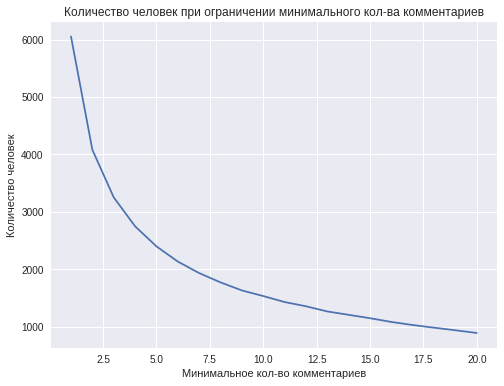

In [269]:
fig = plt.figure(figsize=(8, 6))
plt.plot(range(1,21), uniq_ids)
# plt.xticks(np.linspace(0, 16, 17));
plt.xlabel('Минимальное кол-во комментариев')
plt.ylabel('Количество человек')
plt.title('Количество человек при ограничении минимального кол-ва комментариев');

In [130]:
fig.savefig('temp.png')

In [711]:
with open('unique_ids.pkl', 'wb') as f:
    pickle.dump(unique_ids, f)

In [928]:
with open('unique_ids_10.pkl', 'rb') as f:
    unique_ids = pickle.load(f)

In [785]:
unique_ids = pd.Series(unique_ids).sample(frac=1, random_state=3).values

In [908]:
# unique_ids = pd.Series(unique_ids).sample(frac=1, random_state=3).values
train_idxs = unique_ids[:len(unique_ids) * 0.8]
test_idxs = unique_ids[len(unique_ids) * 0.8:]

train_comments = comments[[i in train_idxs for i in comments.from_id]]
test_comments = comments[[i in test_idxs for i in comments.from_id]]

train_comments.is_gum.value_counts()

0.0    45254
1.0    37810
Name: is_gum, dtype: int64

In [929]:
print(test_comments.is_gum.value_counts())

0.0    9671
1.0    8301
Name: is_gum, dtype: int64


In [910]:
len(train_idxs), len(test_idxs)

(1088, 273)

In [932]:
test_comments.is_gum.value_counts()

0.0    9671
1.0    8301
Name: is_gum, dtype: int64

In [916]:
train_comments.is_gum.value_counts()

1.0    45254
0.0    45254
Name: is_gum, dtype: int64

In [917]:
train_comments.shape, test_comments.shape

((90508, 10), (17972, 10))

In [918]:
X_train = vectorizer.transform(train_comments.text.values)
X_test = vectorizer.transform(test_comments.text.values)

In [919]:
X_test.sum(axis=1)

matrix([[7],
        [1],
        [6],
        ..., 
        [7],
        [2],
        [4]])

In [920]:
lr = lm.LogisticRegression() # class_weight='balanced')

In [921]:
lr.fit(X_train, train_comments.is_gum.values)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [922]:
lr.score(X_test, test_comments.is_gum.values)

0.52203427553972848

In [923]:
prediction = lr.predict(X_test)

In [924]:
test_comments['prediction'] = prediction

/home/digitman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [926]:
y_true = test_comments.groupby('from_id').agg(np.median)['is_gum'].values
y_pred = np.floor(test_comments.groupby('from_id').agg(np.median)['prediction'].values)
accuracy_score(y_true, y_pred)

0.58608058608058611

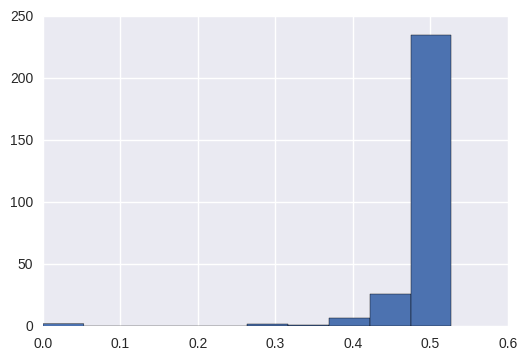

In [904]:
test_comments.groupby('from_id').agg(np.std)['prediction'].hist()

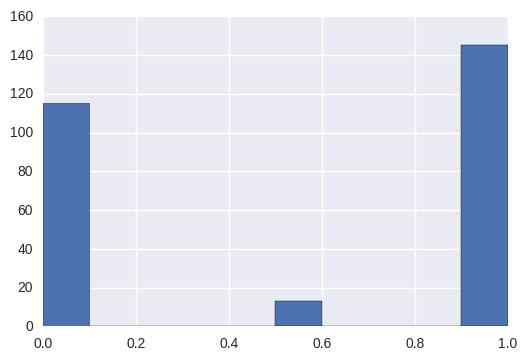

In [905]:
test_comments.groupby('from_id').agg(np.median)['prediction'].hist()